In [22]:
import re
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, LeaveOneGroupOut, GroupKFold, StratifiedShuffleSplit, train_test_split

In [551]:
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv')
df_graze = pd.read_csv('../data/ground/grazing/CARM_ActualGrazingInfov4_2013-2023.csv')

In [552]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Prep data

In [553]:
df_fq = df_fq.drop(columns=['Concatenate', 'Herd', 'Pasture Name',
       'Rotation', r"Tag #'s", 'Notes',
       'Ecological Site', 'HerdTreat', 'Phase'])

In [554]:
df_fq_raw = df_fq.copy()

In [555]:
df_fq = df_fq.groupby(['Year', 'PastureID', 'Treatment', 'Date', 'Week']).mean().reset_index()

In [556]:
df_fq = df_fq.rename(columns={'Crude Protein (%)': 'CP',
                              'DOM(%)': 'DOM',
                              'Treatment': 'Treatment_full'})

In [557]:
treatment_rename_dict = {
    'CARM1': 'CARM',
    'CARM2': 'CARM',
    'Paired TRM1': 'TRM',
    'Paired TRM2': 'TRM',
    'CARM77': 'CARM',
    'CARM107': 'CARM'
    
}
pasture_rename_dict = {
    'NH': '10S'
}

In [558]:
df_fq['Treatment'] = df_fq['Treatment_full'].apply(lambda x: treatment_rename_dict[x] if x in treatment_rename_dict.keys() else x)

In [559]:
df_graze['corr_fact'] = df_graze['comments'].apply(lambda x: 0.5 if 'fence open' in str(x) else 1.0)
df_graze['NumSteers_corr']= df_graze['NumSteers'] * df_graze['corr_fact']

In [560]:
df_graze['PastureID'] = df_graze['PastureCode'].apply(lambda x: pasture_rename_dict[x] if x in pasture_rename_dict.keys() else x)

In [561]:
df_fq = pd.merge(df_fq, df_graze[['PastureID', 'Year', 'NumSteers_corr']],
                 how='left', on=['PastureID', 'Year'])

In [562]:
df_fq['period'] = np.ceil(df_fq['Week']/4).astype(int)
feature_names = ['NDVI', 'NDVI_d30', 'iNDVI', 't_SOS', 'iNDVI_dry', 'NumSteers_corr']
#feature_names = ['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry', 'NumSteers_corr']

In [563]:
df_fq.columns#['period'].value_counts()

Index(['Year', 'PastureID', 'Treatment_full', 'Date', 'Week', 'CP', 'DOM',
       'DOM/CP', 'Fecal Nitrogen (%)', 'Fecal Phosphorus (%)', 'Julian Day',
       'Precip(mm)', 'WOY', 'DOY', 'NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG',
       'iNDVI_dry', 'SOS_doy', 't_SOS', 'Treatment', 'NumSteers_corr',
       'period'],
      dtype='object')

In [564]:
df_sub = df_fq[~df_fq['DOM'].isna()].copy()
df_sub = df_sub[~df_sub['CP'].isna()].copy()
#df_sub = df_sub[df_sub['Treatment'] == 'TRM'].copy()

<Axes: >

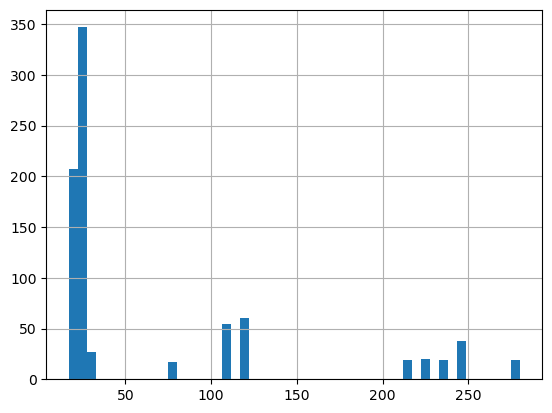

In [565]:
df_sub['NumSteers_corr'].hist(bins=50)

In [566]:
yr_type_dict = {
    2014: 'Wet',
    2015: 'Wet',
    2016: 'Avg',
    2017: 'Avg',
    2018: 'Avg',
    2019: 'Avg',
    2020: 'Dry',
    2021: 'Avg',
    2022: 'Dry',
    2023: 'Wet',
}

In [567]:
df_sub['Year_str'] = df_sub['Year'].astype(str)
df_sub['Year_type'] = df_sub['Year'].apply(lambda x: yr_type_dict[x])

In [568]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [569]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [570]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [571]:
def plot_pcs(df, ax, y_var, var_names, ellipse_var, hue_var, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df[y_var]
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  [y_var]
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue=hue_var,
                    edgecolor='none', alpha=0.3, s=6, palette='tab10', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), y_var, ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df[ellipse_var].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=3))
        confidence_ellipse(df['PC'+str(pcs[0])][df[ellipse_var] == k], 
                           df['PC'+str(pcs[1])][df[ellipse_var] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [572]:
var_names = ['NDVI', 'NDVI_d30', 'iNDVI', 'iNDVI_dry','t_SOS']

In [573]:
#names = ['Plot (random k-fold)', 'Pasture (spatial block)', 'Ecosite (spatial strata)', 'Year (temporal)']

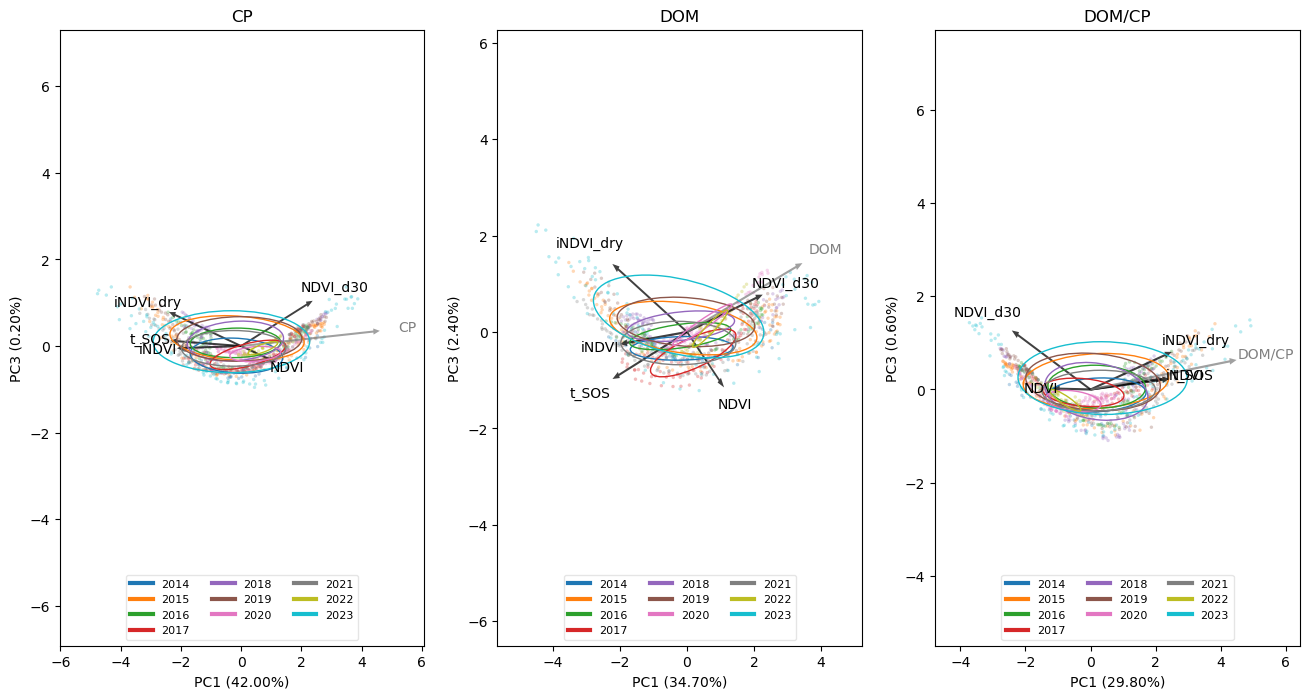

In [574]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 8))
df = df_sub
for idx, i in enumerate(['CP', 'DOM', 'DOM/CP']):
    plot_pcs(df=df,
             ax=axs[idx],
             y_var=i,
             hue_var='Year_str',
             ellipse_var='Year_str',
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = var_names,
             #vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=i,
             n_std=1.0,
             pcs=[1,3])
    leg = axs[idx].get_legend()
    #if idx > 1:
    leg.set_loc('lower center')
    #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
    axs[idx].legend(leg.legend_handles,
                              [x.get_text() for x in leg.get_texts()], 
                              ncol=3, loc='lower center',
                              frameon=True, framealpha=0.5, 
                              fontsize=8)

In [575]:
df_sub['outlier_cp_upr'] = df_sub.groupby(['Treatment', 'period'])['CP'].transform(lambda x: x.mean()+x.std()*3)
df_sub['outlier_cp_lwr'] = df_sub.groupby(['Treatment', 'period'])['CP'].transform(lambda x: x.mean()-x.std()*3)
df_sub['outlier_cp'] = df_sub.apply(
    lambda x: 1 if (x['CP'] > x['outlier_cp_upr']) or (x['CP'] < x['outlier_cp_lwr']) else 0, axis=1)

df_sub['outlier_dom_upr'] = df_sub.groupby(['Treatment', 'period'])['DOM'].transform(lambda x: x.mean()+x.std()*3)
df_sub['outlier_dom_lwr'] = df_sub.groupby(['Treatment', 'period'])['DOM'].transform(lambda x: x.mean()-x.std()*3)
df_sub['outlier_dom'] = df_sub.apply(
    lambda x: 1 if (x['DOM'] > x['outlier_dom_upr']) or (x['DOM'] < x['outlier_dom_lwr']) else 0, axis=1)

df_sub['outlier_ratio_upr'] = df_sub.groupby(['Treatment', 'period'])['DOM/CP'].transform(lambda x: x.mean()+x.std()*3)
df_sub['outlier_ratio_lwr'] = df_sub.groupby(['Treatment', 'period'])['DOM/CP'].transform(lambda x: x.mean()-x.std()*3)
df_sub['outlier_ratio'] = df_sub.apply(
    lambda x: 1 if (x['DOM/CP'] > x['outlier_ratio_upr']) or (x['DOM/CP'] < x['outlier_ratio_lwr']) else 0, axis=1)

In [576]:
df_sub['outlier_all'] = (df_sub[['outlier_cp', 'outlier_dom', 'outlier_ratio']].sum(axis=1) > 0).astype(int)

<Axes: title={'center': 'Treatment = CARM'}, xlabel='period', ylabel='CP'>

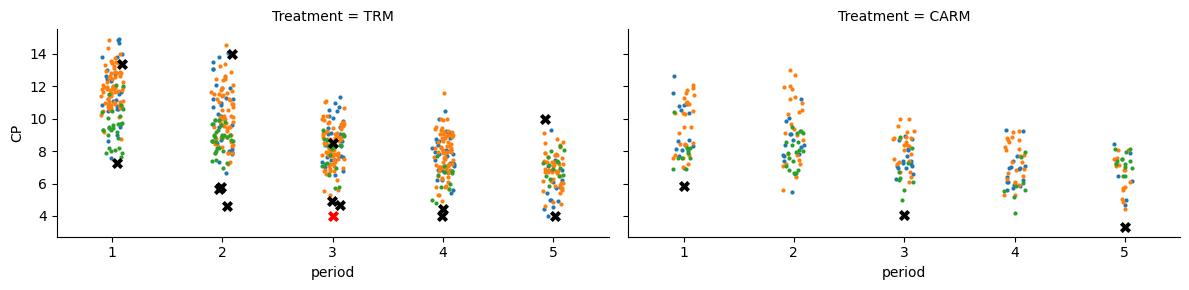

In [577]:
g = sns.FacetGrid(data=df_sub[df_sub['outlier_all'] == 0],
                col='Treatment',
                hue='Year_type', 
                height=3, aspect=2)
g.map_dataframe(sns.stripplot, x='period', y='CP', size=3, legend=True)
sns.stripplot(x='period', y='CP', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_cp'] == 0) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='CP', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_cp'] == 0) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='CP', data=df_sub[(df_sub['outlier_cp'] == 1) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='red', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='CP', data=df_sub[(df_sub['outlier_cp'] == 1) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='red', marker='X', size=8, legend=False)
#g.map_dataframe(sns.stripplot, x='period', y='CP', legend=True, data=, size=20)

<Axes: title={'center': 'Treatment = CARM'}, xlabel='period', ylabel='DOM'>

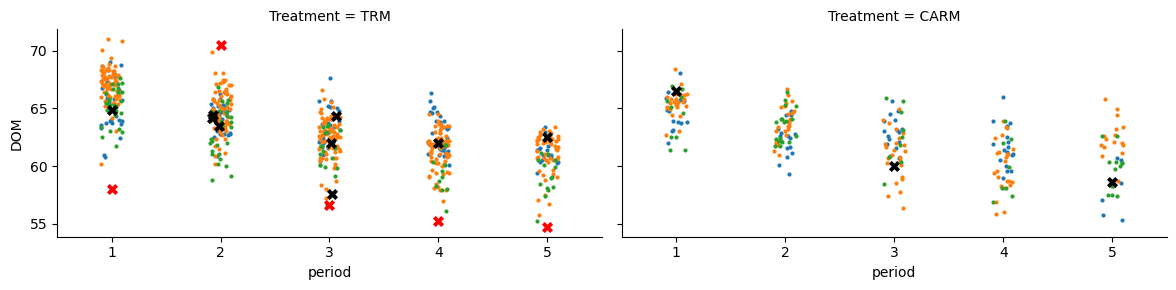

In [578]:
g = sns.FacetGrid(data=df_sub[df_sub['outlier_all'] == 0],
                col='Treatment',
                hue='Year_type', 
                height=3, aspect=2)
g.map_dataframe(sns.stripplot, x='period', y='DOM', size=3, legend=True)
sns.stripplot(x='period', y='DOM', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_dom'] == 0) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_dom'] == 0) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM', data=df_sub[(df_sub['outlier_dom'] == 1) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='red', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM', data=df_sub[(df_sub['outlier_dom'] == 1) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='red', marker='X', size=8, legend=False)

<Axes: title={'center': 'Treatment = CARM'}, xlabel='period', ylabel='DOM/CP'>

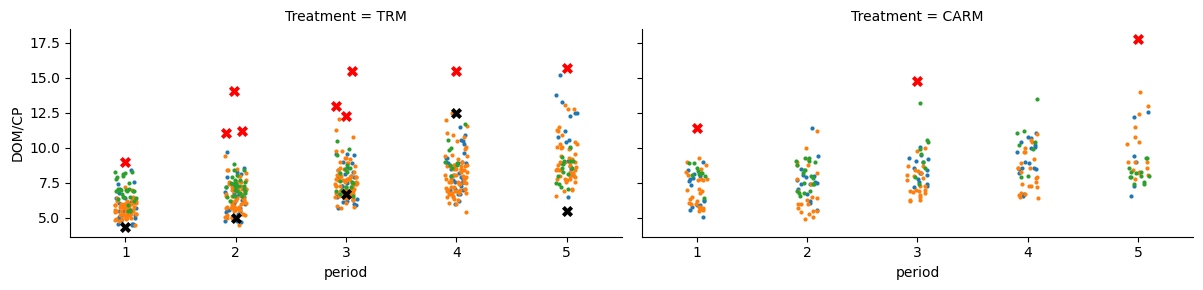

In [579]:
g = sns.FacetGrid(data=df_sub[df_sub['outlier_all'] == 0],
                col='Treatment',
                hue='Year_type', 
                height=3, aspect=2)
g.map_dataframe(sns.stripplot, x='period', y='DOM/CP', size=3, legend=True)
sns.stripplot(x='period', y='DOM/CP', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_ratio'] == 0) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM/CP', data=df_sub[(df_sub['outlier_all'] == 1) & (df_sub['outlier_ratio'] == 0) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='black', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM/CP', data=df_sub[(df_sub['outlier_ratio'] == 1) & (df_sub['Treatment'] == 'TRM')],
              ax=g.axes.flatten()[0], color='red', marker='X', size=8, legend=False)
sns.stripplot(x='period', y='DOM/CP', data=df_sub[(df_sub['outlier_ratio'] == 1) & (df_sub['Treatment'] == 'CARM')],
              ax=g.axes.flatten()[1], color='red', marker='X', size=8, legend=False)

In [580]:
#sns.lmplot(x='NDVI', y='DOM', hue='period', data=df_sub)

In [581]:
#sns.catplot(x='period', y='CP', data=df_sub,
#            col='Treatment', row='Year', hue='PastureID', 
#            height=3, aspect=2,
#            legend=False)

In [474]:
#sns.catplot(x='period', y='DOM', data=df_sub,
#            col='Treatment', row='Year', hue='PastureID', 
#            height=3, aspect=2,
#            legend=False)

In [475]:
#sns.catplot(x='period', y='DOM/CP', data=df_sub,
#            col='Treatment', row='Year', hue='PastureID', 
#            height=3, aspect=2,
#            legend=False)

In [582]:
rand_st = 2313
df_train, df_test = train_test_split(df_sub, test_size=0.2, stratify=df_sub['Treatment'], random_state=rand_st)

In [583]:
df_train = df_train[df_train['outlier_all'] == 0]
df_test = df_test[df_test['outlier_all'] == 0]
df_sub = df_sub[df_sub['outlier_all'] == 0]

In [584]:
#df_train = df_train[df_train['Treatment'] == 'TRM'].copy()
#df_sub = df_sub[df_sub['Treatment'] == 'TRM'].copy()

In [585]:
df_sub = df_sub.reset_index(drop=True)

In [586]:
display(df_train['Treatment'].value_counts())
display(df_test['Treatment'].value_counts())

Treatment
TRM     454
CARM    194
Name: count, dtype: int64

Treatment
TRM     113
CARM     49
Name: count, dtype: int64

<Axes: >

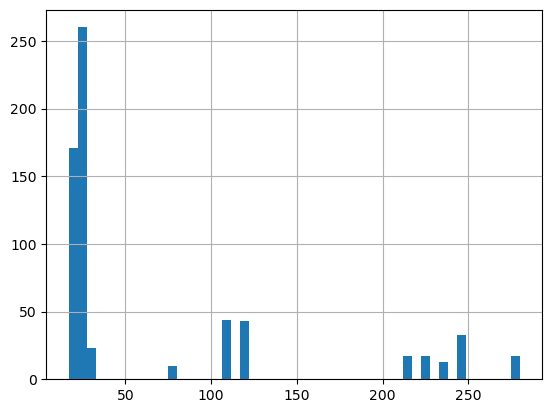

In [587]:
df_train['NumSteers_corr'].hist(bins=50)

<Axes: >

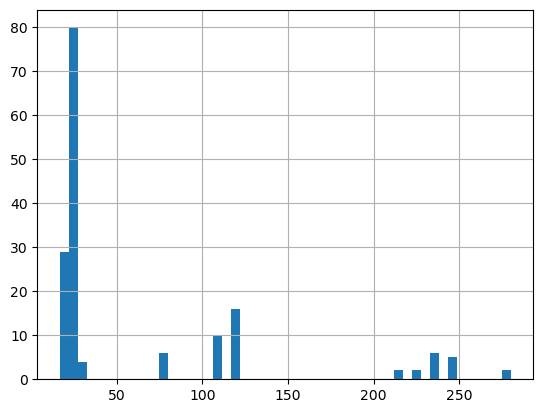

In [588]:
df_test['NumSteers_corr'].hist(bins=50)

# Prep RF model

In [589]:
######
fq_features = df_train[feature_names]
cp_labels = df_train['CP']
dom_labels = df_train['DOM']
strata = df_train['period']
groups = df_train['Year']
fq_features_test = df_test[feature_names]
cp_labels_test = df_test['CP']
dom_labels_test = df_test['DOM']

In [590]:
#df_train['Year'].value_counts()

In [591]:
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAE': 'neg_mean_absolute_error'}
param_grid = {
    #'RF__min_samples_split': [0.0005, 0.001, 0.01, 0.10, 0.15, 0.2],
    'RF__n_estimators': [10, 25, 50, 100, 250],
    'RF__max_samples': [0.1, 0.25, 0.5, 0.75, 0.90],
    'RF__max_features': [1, 2, 3, 4, 5],
}

logo = LeaveOneGroupOut()
skf = StratifiedKFold(n_splits=5, random_state=rand_st, shuffle=True)
sgkf = StratifiedGroupKFold(n_splits=5, random_state=rand_st, shuffle=True)
gkf = GroupKFold(n_splits=5)

# Create a based model
rf_pipe = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_jobs=1))
                ])


# Fit with steer count

## Fit CP

In [592]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features, strata)
sgkf_cv = skf.split(fq_features, strata, groups=groups)
logo_cv = logo.split(fq_features, cp_labels, groups=groups)
gkf_cv = gkf.split(fq_features, cp_labels, groups=groups)

cv_fnl = sgkf_cv

cp_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='R2', return_train_score=True,
                               cv=cv_fnl, n_jobs=-1, verbose=0)
# Fit the grid search to the data
cp_grid_search.fit(fq_features, cp_labels)
cp_results = cp_grid_search.cv_results_

In [593]:
df_results_cp = pd.DataFrame({k:cp_results[k] for k in cp_results.keys() if not k.startswith('split')})
df_results_cp.loc[df_results_cp['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_cp['param_RF__max_samples'] = df_results_cp['param_RF__max_samples'].astype(str)

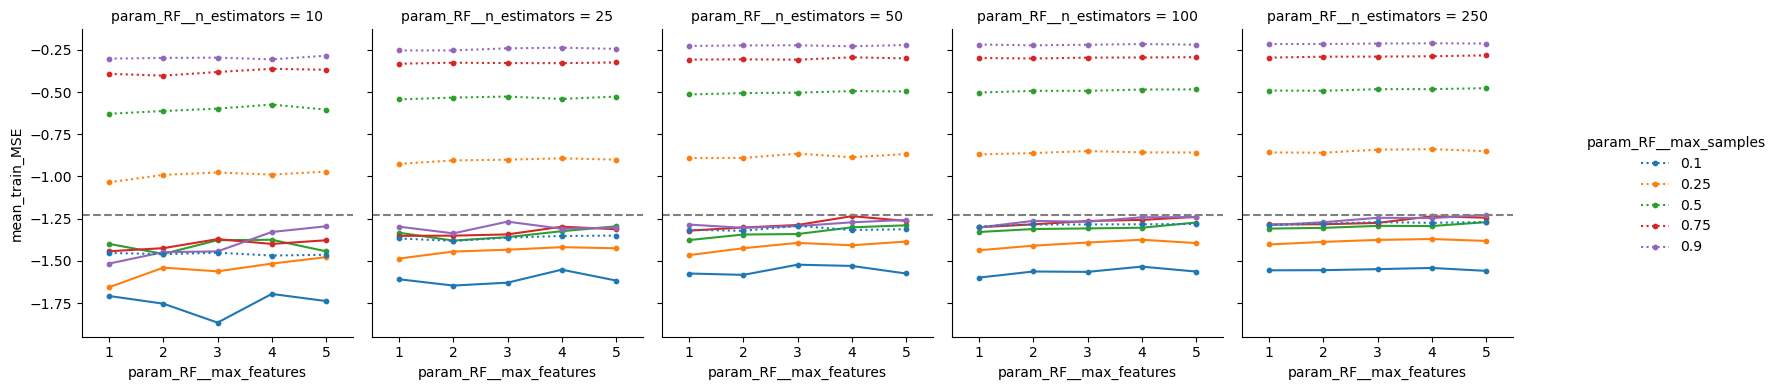

In [594]:
p = sns.FacetGrid(data=df_results_cp,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((-1.5, -0.1))
    ax.axhline(y=df_results_cp['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

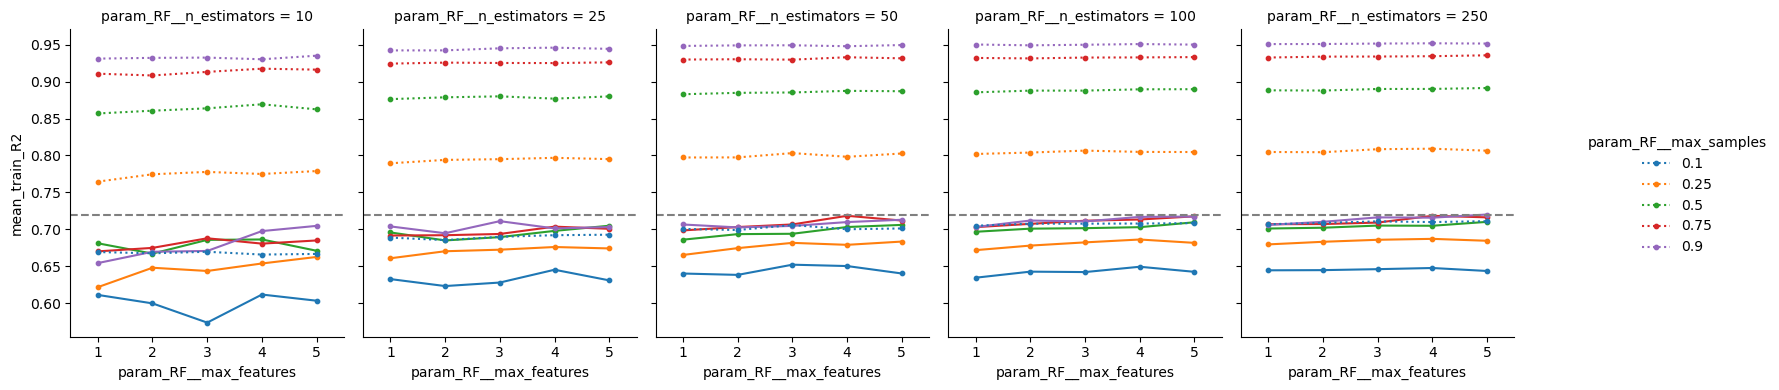

In [595]:
p = sns.FacetGrid(data=df_results_cp,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((0.5, 1.0))
    ax.axhline(y=df_results_cp['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [596]:
use_best = True
if use_best:
    cp_max_features = cp_grid_search.best_params_['RF__max_features']
    cp_n_estimators = cp_grid_search.best_params_['RF__n_estimators']
    #cp_min_samples_split = cp_grid_search.best_params_['RF__min_samples_split']
    cp_max_samples = cp_grid_search.best_params_['RF__max_samples']
else:
    # with t_peak_IRG
    #cp_max_features = 1
    #cp_n_estimators = 50
    #cp_min_samples_split = 0.001
    #cp_max_samples = 0.75

    cp_max_features = 4
    cp_n_estimators = 100
    #cp_min_samples_split = 0.01
    cp_max_samples = 0.9
    
    best_result_manual_cp = df_results_cp[(df_results_cp['param_RF__max_features'] == cp_max_features) &
    (df_results_cp['param_RF__n_estimators'] == cp_n_estimators) &
    #(df_results_cp['param_RF__min_samples_split'] == cp_min_samples_split) &
    (df_results_cp['param_RF__max_samples'] == str(cp_max_samples))]
    display(best_result_manual_cp.drop(columns=['params']))

    print('R^2-CV: ' + str(cp_results['mean_test_R2'][cp_results['rank_test_MSE'] == 2]))
    print('R^2-CV std: ' + str(cp_results['std_test_R2'][cp_results['rank_test_MSE'] == 2]))
    print('MSE-CV: ' + str(-1.0 * cp_results['mean_test_MSE'][cp_results['rank_test_MSE'] == 2]))
    print('MSE-CV std: ' + str(cp_results['std_test_MSE'][cp_results['rank_test_MSE'] == 2]))
    print('RMSE-CV: ' + str(np.mean(
        np.sqrt([-1.0 * value[cp_results['rank_test_MSE'] == 2] for
                 key, value in cp_results.items() if re.search('split+\d_train_MSE', key)]))))
    print('RMSE-CV std: ' + str(np.std(
        np.sqrt([-1.0 * value[cp_results['rank_test_MSE'] == 2] for
                 key, value in cp_results.items() if re.search('split+\d_train_MSE', key)]))))

In [597]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators,
                                                 max_features=cp_max_features, 
                                                 #min_samples_split=cp_min_samples_split, 
                                                 max_samples=cp_max_samples,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(fq_features, cp_labels)

# Use the forest's predict method on the test data
pred_cp = rf_cp_fnl.predict(fq_features)
pred_cp_test = rf_cp_fnl.predict(fq_features_test)
# Calculate the absolute errors_cp
errors_cp = np.mean((pred_cp - cp_labels)**2)
errors_cp_test = np.mean((pred_cp_test - cp_labels_test)**2)
# Print out the mean absolute error (mae)
print('RMSE Train:', round(np.sqrt(np.mean(errors_cp)), 2))
print('RMSE Test:', round(np.sqrt(np.mean(errors_cp_test)), 2))
#plt.figure()
#plt.scatter(pred_cp, cp_labels)
#abline(1, 0)

RMSE Train: 0.45
RMSE Test: 1.12


## Fit DOM

In [598]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features, strata)
sgkf_cv = skf.split(fq_features, strata, groups=groups)
logo_cv = logo.split(fq_features, cp_labels, groups=groups)
gkf_cv = gkf.split(fq_features, cp_labels, groups=groups)

cv_fnl = sgkf_cv

dom_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='R2', return_train_score=True,
                               cv=cv_fnl, n_jobs=-1, verbose=0)

# Fit the grid search to the data
dom_grid_search.fit(fq_features, dom_labels)
dom_results = dom_grid_search.cv_results_

In [599]:
df_results_dom = pd.DataFrame({k:dom_results[k] for k in dom_results.keys() if not k.startswith('split')})
df_results_dom.loc[df_results_dom['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_dom['param_RF__max_samples'] = df_results_dom['param_RF__max_samples'].astype(str)

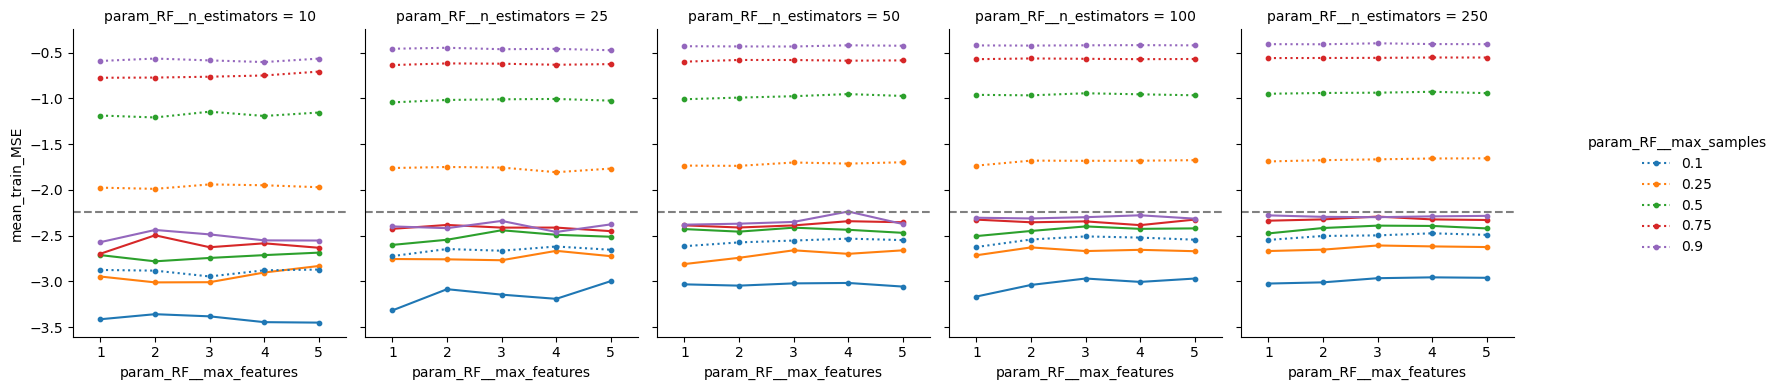

In [600]:
p = sns.FacetGrid(data=df_results_dom,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((-1.5, -0.1))
    ax.axhline(y=df_results_dom['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

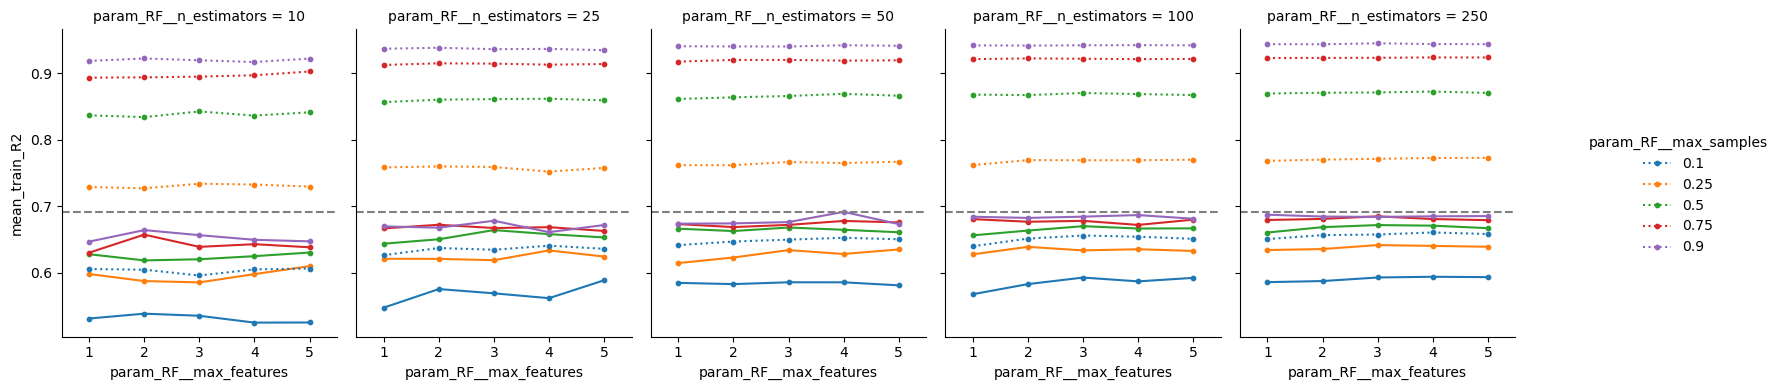

In [601]:
p = sns.FacetGrid(data=df_results_dom,
                  hue='param_RF__max_samples', 
                 # row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((0.5, 1.0))
    ax.axhline(y=df_results_dom['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [602]:
use_best = True
if use_best:
    dom_max_features = dom_grid_search.best_params_['RF__max_features']
    dom_n_estimators = dom_grid_search.best_params_['RF__n_estimators']
    #dom_min_samples_split = dom_grid_search.best_params_['RF__min_samples_split']
    dom_max_samples = dom_grid_search.best_params_['RF__max_samples']
else:
    # with t_peak_IRG
    #dom_max_features = 3
    #dom_n_estimators = 750
    #dom_min_samples_split = 0.001
    #dom_max_samples = 0.9

    dom_max_features = 1
    dom_n_estimators = 250
    dom_min_samples_split = 0.01
    dom_max_samples = 0.75
    
    best_result_manual_dom = df_results_dom[(df_results_dom['param_RF__max_features'] == dom_max_features) &
    (df_results_dom['param_RF__n_estimators'] == dom_n_estimators) &
    (df_results_dom['param_RF__min_samples_split'] == dom_min_samples_split) &
    (df_results_dom['param_RF__max_samples'] == str(dom_max_samples))]
    display(best_result_manual_dom.drop(columns=['params']))


In [603]:
# Create a based model
rf_dom_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators,
                                                 max_features=dom_max_features, 
                                                 #min_samples_split=dom_min_samples_split, 
                                                 max_samples=dom_max_samples,
                                                 n_jobs=-1))
                ])
rf_dom_fnl.fit(fq_features, dom_labels)

# Use the forest's predict method on the test data
pred_dom = rf_dom_fnl.predict(fq_features)
pred_dom_test = rf_dom_fnl.predict(fq_features_test)
# Calculate the absolute errors_dom
errors_dom = np.mean((pred_dom - dom_labels)**2)
errors_dom_test = np.mean((pred_dom_test - dom_labels_test)**2)
# Print out the mean absolute error (mae)
print('RMSE Train:', round(np.sqrt(np.mean(errors_dom)), 2))
print('RMSE Test:', round(np.sqrt(np.mean(errors_dom_test)), 2))
#plt.figure()
#plt.scatter(pred_dom, dom_labels)
#abline(1, 0)

RMSE Train: 0.63
RMSE Test: 1.62


# Fit without steer count

In [604]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata)
sgkf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata, groups=groups)
logo_cv = logo.split(fq_features.drop(columns='NumSteers_corr'), cp_labels, groups=groups)
gkf_cv = gkf.split(fq_features.drop(columns='NumSteers_corr'), cp_labels, groups=groups)

cv_fnl = sgkf_cv
cp_grid_search_ns = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='R2', return_train_score=True,
                               cv=cv_fnl, n_jobs=-1, verbose=0)
# Fit the grid search to the data
cp_grid_search_ns.fit(fq_features.drop(columns='NumSteers_corr'), cp_labels)
cp_results_ns = cp_grid_search_ns.cv_results_

In [605]:
df_results_cp_ns = pd.DataFrame({k:cp_results_ns[k] for k in cp_results_ns.keys() if not k.startswith('split')})
df_results_cp_ns.loc[df_results_cp_ns['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_cp_ns['param_RF__max_samples'] = df_results_cp_ns['param_RF__max_samples'].astype(str)

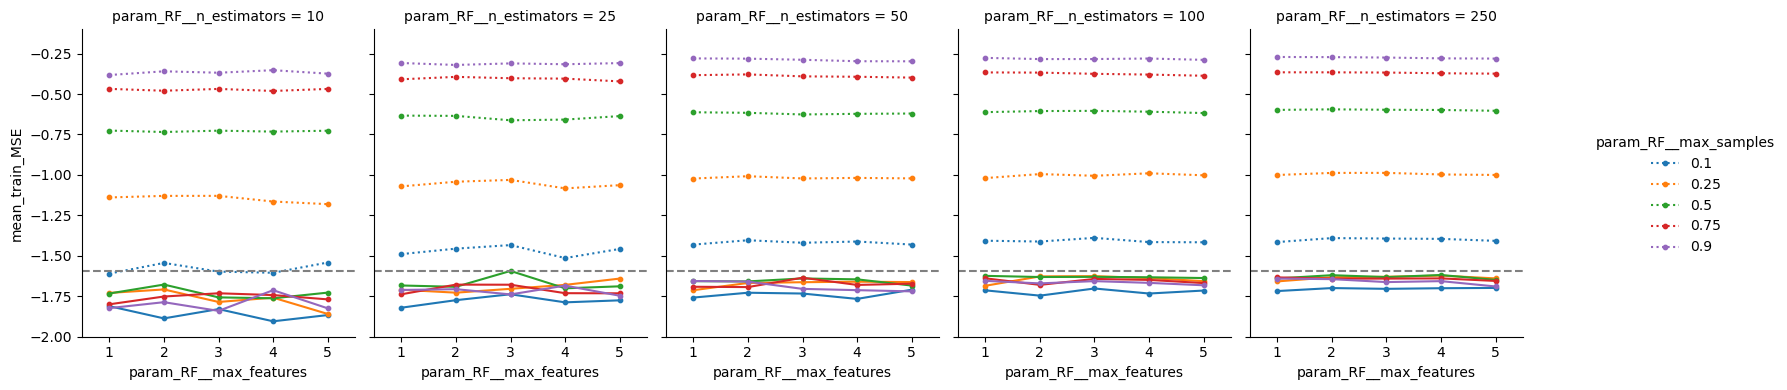

In [606]:
p = sns.FacetGrid(data=df_results_cp_ns,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((-2.0, -0.1))
    ax.axhline(y=df_results_cp_ns['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

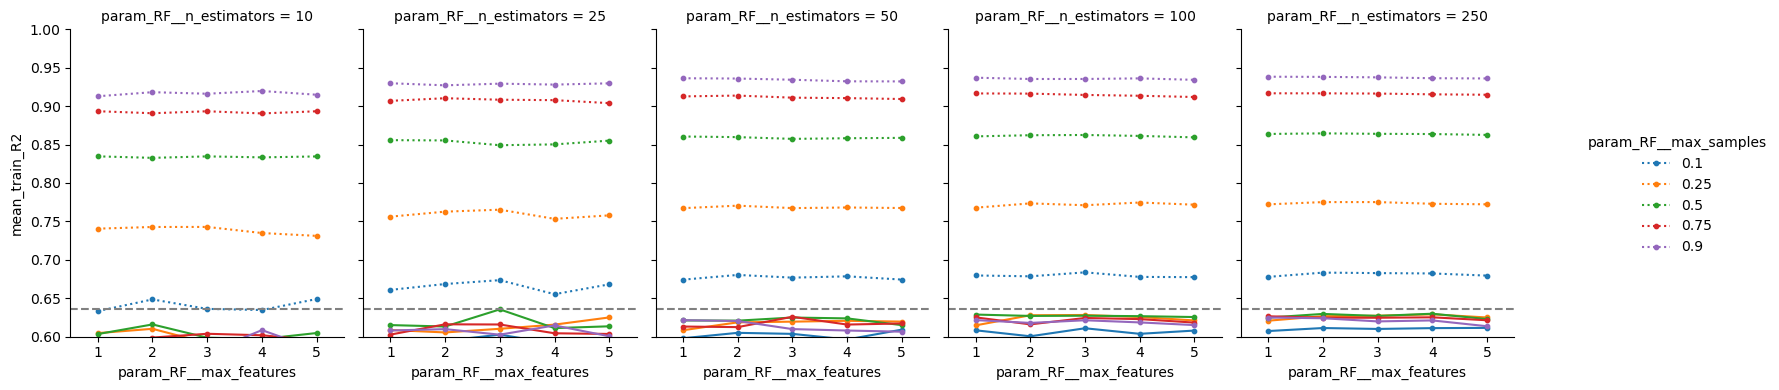

In [607]:
p = sns.FacetGrid(data=df_results_cp_ns,
                  hue='param_RF__max_samples', 
                 # row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((0.6, 1.0))
    ax.axhline(y=df_results_cp_ns['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [608]:
use_best = True
if use_best:
    cp_max_features_ns = cp_grid_search_ns.best_params_['RF__max_features']
    cp_n_estimators_ns = cp_grid_search_ns.best_params_['RF__n_estimators']
    #cp_min_samples_split_ns = cp_grid_search_ns.best_params_['RF__min_samples_split']
    cp_max_samples_ns = cp_grid_search_ns.best_params_['RF__max_samples']
else:
    cp_max_features_ns = 1
    cp_n_estimators_ns = 250
    cp_min_samples_split_ns = 0.01
    cp_max_samples_ns = 0.75


# Create a based model
rf_cp_fnl_ns = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators_ns,
                                                 max_features=cp_max_features_ns, 
                                                 #min_samples_split=cp_min_samples_split_ns, 
                                                 max_samples=cp_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_cp_fnl_ns.fit(fq_features.drop(columns='NumSteers_corr'), cp_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=3, max_samples=0.5,
                                       n_estimators=25, n_jobs=-1))])

In [609]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata)
sgkf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata, groups=groups)
logo_cv = logo.split(fq_features.drop(columns='NumSteers_corr'), cp_labels, groups=groups)
gkf_cv = gkf.split(fq_features.drop(columns='NumSteers_corr'), cp_labels, groups=groups)

cv_fnl = sgkf_cv
dom_grid_search_ns = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='R2', return_train_score=True,
                               cv=cv_fnl, n_jobs=-1, verbose=0)
# Fit the grid search to the data
dom_grid_search_ns.fit(fq_features.drop(columns='NumSteers_corr'), dom_labels)
dom_results_ns = dom_grid_search_ns.cv_results_

In [610]:
df_results_dom_ns = pd.DataFrame({k:dom_results_ns[k] for k in dom_results_ns.keys() if not k.startswith('split')})
df_results_dom_ns.loc[df_results_dom_ns['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_dom_ns['param_RF__max_samples'] = df_results_dom_ns['param_RF__max_samples'].astype(str)

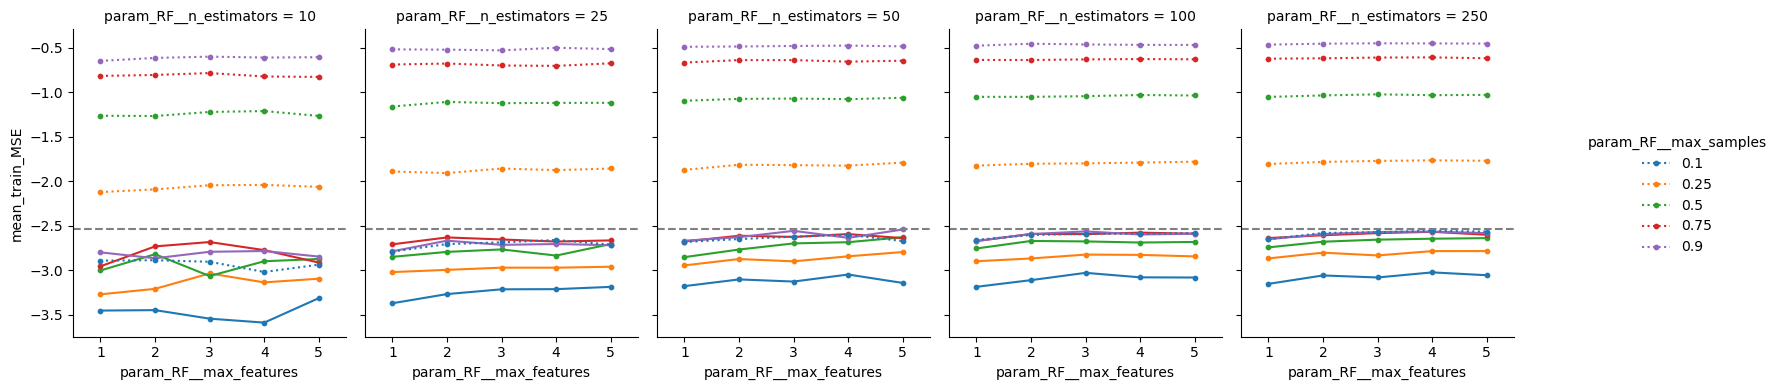

In [611]:
p = sns.FacetGrid(data=df_results_dom_ns,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((-2.0, -0.1))
    ax.axhline(y=df_results_dom_ns['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

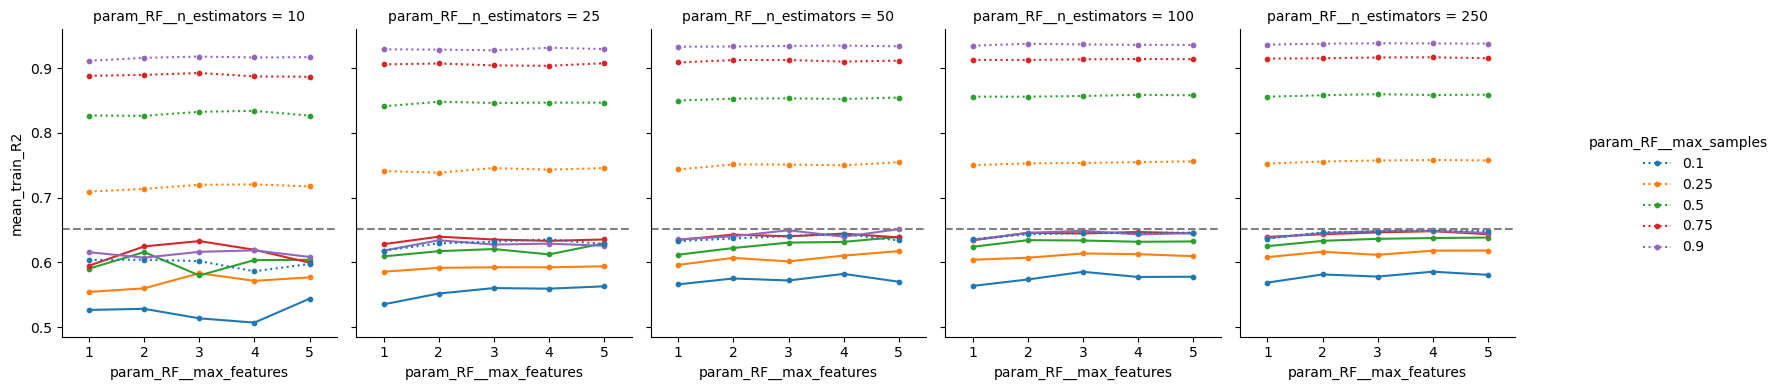

In [612]:
p = sns.FacetGrid(data=df_results_dom_ns,
                  hue='param_RF__max_samples', 
                  #row='param_RF__max_features',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((0.6, 1.0))
    ax.axhline(y=df_results_dom_ns['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [613]:
use_best = True
if use_best:
    dom_max_features_ns = dom_grid_search_ns.best_params_['RF__max_features']
    dom_n_estimators_ns = dom_grid_search_ns.best_params_['RF__n_estimators']
    #dom_min_samples_split_ns = dom_grid_search_ns.best_params_['RF__min_samples_split']
    dom_max_samples_ns = dom_grid_search_ns.best_params_['RF__max_samples']
else:
    # for t_peak_IRG
    #dom_max_features_ns = 1
    #dom_n_estimators_ns = 250
    #dom_min_samples_split_ns = 0.001
    #dom_max_samples_ns = 0.5

    dom_max_features_ns = 1
    dom_n_estimators_ns = 250
    dom_min_samples_split_ns = 0.01
    dom_max_samples_ns = 0.75


# Create a based model
rf_dom_fnl_ns = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators_ns,
                                                 max_features=dom_max_features_ns, 
                                                 #min_samples_split=dom_min_samples_split_ns, 
                                                 max_samples=dom_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_dom_fnl_ns.fit(fq_features.drop(columns='NumSteers_corr'), dom_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=5, max_samples=0.9,
                                       n_estimators=50, n_jobs=-1))])

# Plot results

In [614]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
def corrfunc(x, y, **kwargs):
    data = kwargs.pop('data')
    r, _ = stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

In [615]:
df_test['CP_pred'] = rf_cp_fnl.predict(df_test[feature_names])
df_test['DOM_pred'] = rf_dom_fnl.predict(df_test[feature_names])
df_test['CP_pred_ns'] = rf_cp_fnl_ns.predict(df_test[[x for x in feature_names if x != 'NumSteers_corr']])
df_test['DOM_pred_ns'] = rf_dom_fnl_ns.predict(df_test[[x for x in feature_names if x != 'NumSteers_corr']])

In [616]:
r2_trm_cp = r2_score(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'TRM'])
r_trm_cp, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'TRM'])
bias_trm_cp = np.mean(df_test['CP_pred'][df_test['Treatment'] == 'TRM'] - df_test['CP'][df_test['Treatment'] == 'TRM'])

r2_trm_cp_ns = r2_score(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'])
r_trm_cp_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'])
bias_trm_cp_ns = np.mean(df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'] - df_test['CP'][df_test['Treatment'] == 'TRM'])

r2_carm_cp = r2_score(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'CARM'])
r_carm_cp, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'CARM'])
bias_carm_cp = np.mean(df_test['CP_pred'][df_test['Treatment'] == 'CARM'] - df_test['CP'][df_test['Treatment'] == 'CARM'])

r2_carm_cp_ns = r2_score(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'])
r_carm_cp_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'])
bias_carm_cp_ns = np.mean(df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'] - df_test['CP'][df_test['Treatment'] == 'CARM'])

r2_trm_dom = r2_score(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'TRM'])
r_trm_dom, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'TRM'])
bias_trm_dom = np.mean(df_test['DOM_pred'][df_test['Treatment'] == 'TRM'] - df_test['DOM'][df_test['Treatment'] == 'TRM'])

r2_trm_dom_ns = r2_score(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'])
r_trm_dom_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'])
bias_trm_dom_ns = np.mean(df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'] - df_test['DOM'][df_test['Treatment'] == 'TRM'])

r2_carm_dom = r2_score(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'CARM'])
r_carm_dom, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'CARM'])
bias_carm_dom = np.mean(df_test['DOM_pred'][df_test['Treatment'] == 'CARM'] - df_test['DOM'][df_test['Treatment'] == 'CARM'])

r2_carm_dom_ns = r2_score(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'])
r_carm_dom_ns, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'])
bias_carm_dom_ns = np.mean(df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'] - df_test['DOM'][df_test['Treatment'] == 'CARM'])

Text(0, 0.5, '')

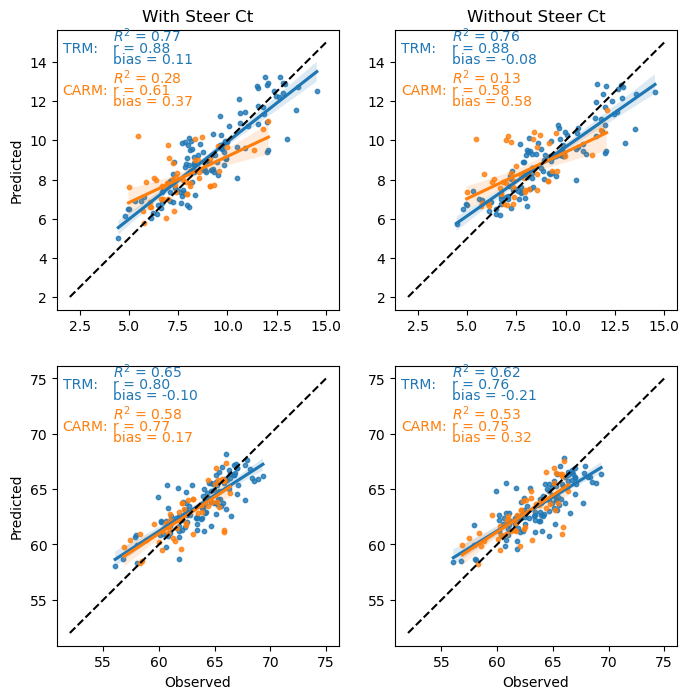

In [617]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.regplot(x='CP', y='CP_pred', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[0,0])
sns.regplot(x='CP', y='CP_pred', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[0,0])
axs[0,0].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[0,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_trm_cp),
                  xy=(.20, .96), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("r = {:.2f}".format(r_trm_cp),
                  xy=(.20, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("bias = {:.2f}".format(bias_trm_cp),
                  xy=(.20, .88), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_carm_cp),
                  xy=(.20, .81), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("r = {:.2f}".format(r_carm_cp),
                  xy=(.20, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("bias = {:.2f}".format(bias_carm_cp),
                  xy=(.20, .73), xycoords=axs[0,0].transAxes, color='tab:orange')


sns.regplot(x='CP', y='CP_pred_ns', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[0,1])
sns.regplot(x='CP', y='CP_pred_ns', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[0,1])
axs[0,1].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[0,1].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("$R^2$ = {:.2f}".format(r2_trm_cp_ns),
                  xy=(.20, .96), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("r = {:.2f}".format(r_trm_cp_ns),
                  xy=(.20, .92), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("bias = {:.2f}".format(bias_trm_cp_ns),
                  xy=(.20, .88), xycoords=axs[0,1].transAxes, color='tab:blue')

axs[0,1].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("$R^2$ = {:.2f}".format(r2_carm_cp_ns),
                  xy=(.20, .81), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("r = {:.2f}".format(r_carm_cp_ns),
                  xy=(.20, .77), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("bias = {:.2f}".format(bias_carm_cp_ns),
                  xy=(.20, .73), xycoords=axs[0,1].transAxes, color='tab:orange')

sns.regplot(x='DOM', y='DOM_pred', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[1,0])
sns.regplot(x='DOM', y='DOM_pred', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[1,0])
axs[1,0].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')
axs[1,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_trm_dom),
                  xy=(.20, .96), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("r = {:.2f}".format(r_trm_dom),
                  xy=(.20, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("bias = {:.2f}".format(bias_trm_dom),
                  xy=(.20, .88), xycoords=axs[1,0].transAxes, color='tab:blue')

axs[1,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_carm_dom),
                  xy=(.20, .81), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("r = {:.2f}".format(r_carm_dom),
                  xy=(.20, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("bias = {:.2f}".format(bias_carm_dom),
                  xy=(.20, .73), xycoords=axs[1,0].transAxes, color='tab:orange')

sns.regplot(x='DOM', y='DOM_pred_ns', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[1,1])
sns.regplot(x='DOM', y='DOM_pred_ns', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[1,1])
axs[1,1].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')
axs[1,1].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("$R^2$ = {:.2f}".format(r2_trm_dom_ns),
                  xy=(.20, .96), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("r = {:.2f}".format(r_trm_dom_ns),
                  xy=(.20, .92), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("bias = {:.2f}".format(bias_trm_dom_ns),
                  xy=(.20, .88), xycoords=axs[1,1].transAxes, color='tab:blue')

axs[1,1].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("$R^2$ = {:.2f}".format(r2_carm_dom_ns),
                  xy=(.20, .81), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("r = {:.2f}".format(r_carm_dom_ns),
                  xy=(.20, .77), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("bias = {:.2f}".format(bias_carm_dom_ns),
                  xy=(.20, .73), xycoords=axs[1,1].transAxes, color='tab:orange')

axs[0,0].set_title('With Steer Ct')
axs[0,1].set_title('Without Steer Ct')
axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,0].set_ylabel('')
axs[0,1].set_ylabel('')
axs[0,0].set_ylabel('Predicted')
axs[1,0].set_ylabel('Predicted')
axs[1,0].set_xlabel('Observed')
axs[1,1].set_xlabel('Observed')
axs[1,1].set_ylabel('')

<Axes: xlabel='Date', ylabel='CP'>

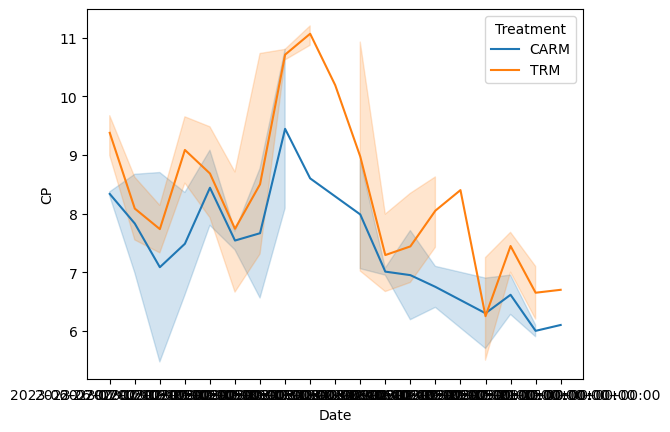

In [621]:
sns.lineplot(x='Date', y='CP', data=df_sub[df_sub['Year'] == 2023], hue='Treatment')

<Axes: xlabel='Date', ylabel='DOM(%)'>

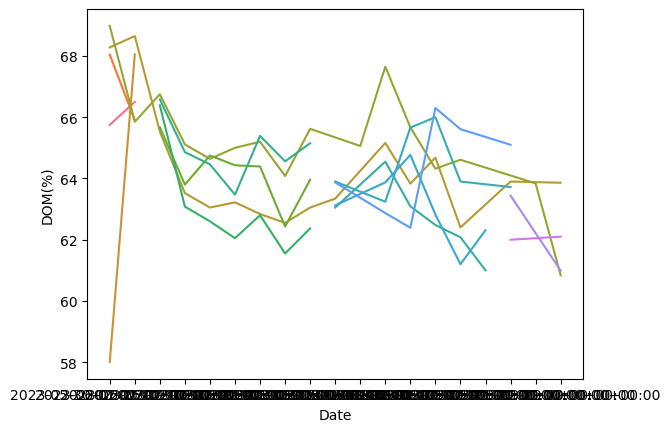

In [155]:
sns.lineplot(x='Date', y='DOM(%)', data=df_fq[df_fq['Year'] == 2023], hue='PastureID', legend=False)

# Fit final models without steer count

In [622]:
feature_names_fnl = [x for x in feature_names if x != 'NumSteers_corr']

In [623]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators_ns,
                                                 max_features=cp_max_features_ns, 
                                                 #min_samples_split=cp_min_samples_split_ns, 
                                                 max_samples=cp_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(df_sub[feature_names_fnl], df_sub['CP'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=3, max_samples=0.5,
                                       n_estimators=25, n_jobs=-1))])

In [624]:
# Create a based model
rf_dom_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators_ns,
                                                 max_features=dom_max_features_ns, 
                                                 #min_samples_split=dom_min_samples_split_ns, 
                                                 max_samples=dom_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_dom_fnl.fit(df_sub[feature_names_fnl], df_sub['DOM'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=5, max_samples=0.9,
                                       n_estimators=50, n_jobs=-1))])

In [625]:
df_sub['CP_pred'] = rf_cp_fnl.predict(df_sub[feature_names_fnl])
df_sub['DOM_pred'] = rf_dom_fnl.predict(df_sub[feature_names_fnl])

In [635]:
df_sub['Year'] = df_sub['Year'].astype(str)

In [633]:
df_fq.columns

Index(['Year', 'PastureID', 'Treatment_full', 'Date', 'Week', 'CP', 'DOM',
       'DOM/CP', 'Fecal Nitrogen (%)', 'Fecal Phosphorus (%)', 'Julian Day',
       'Precip(mm)', 'WOY', 'DOY', 'NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG',
       'iNDVI_dry', 'SOS_doy', 't_SOS', 'Treatment', 'NumSteers_corr',
       'period', 'CP_pred', 'DOM_pred'],
      dtype='object')

In [637]:
df_fq = df_fq[(df_fq['CP'].notnull()) & (df_fq['DOM'].notnull())].copy()
df_fq = pd.merge(df_fq, df_sub[['Year', 'PastureID', 'Date', 'outlier_all']], how='left', on=['Year', 'PastureID', 'Date'])
df_fq = df_fq[df_fq['outlier_all'] == 0]

In [638]:
df_fq['CP_pred'] = rf_cp_fnl.predict(df_fq[feature_names_fnl])
df_fq['DOM_pred'] = rf_dom_fnl.predict(df_fq[feature_names_fnl])

In [639]:
df_fq['Year'] = df_fq['Year'].astype(str)

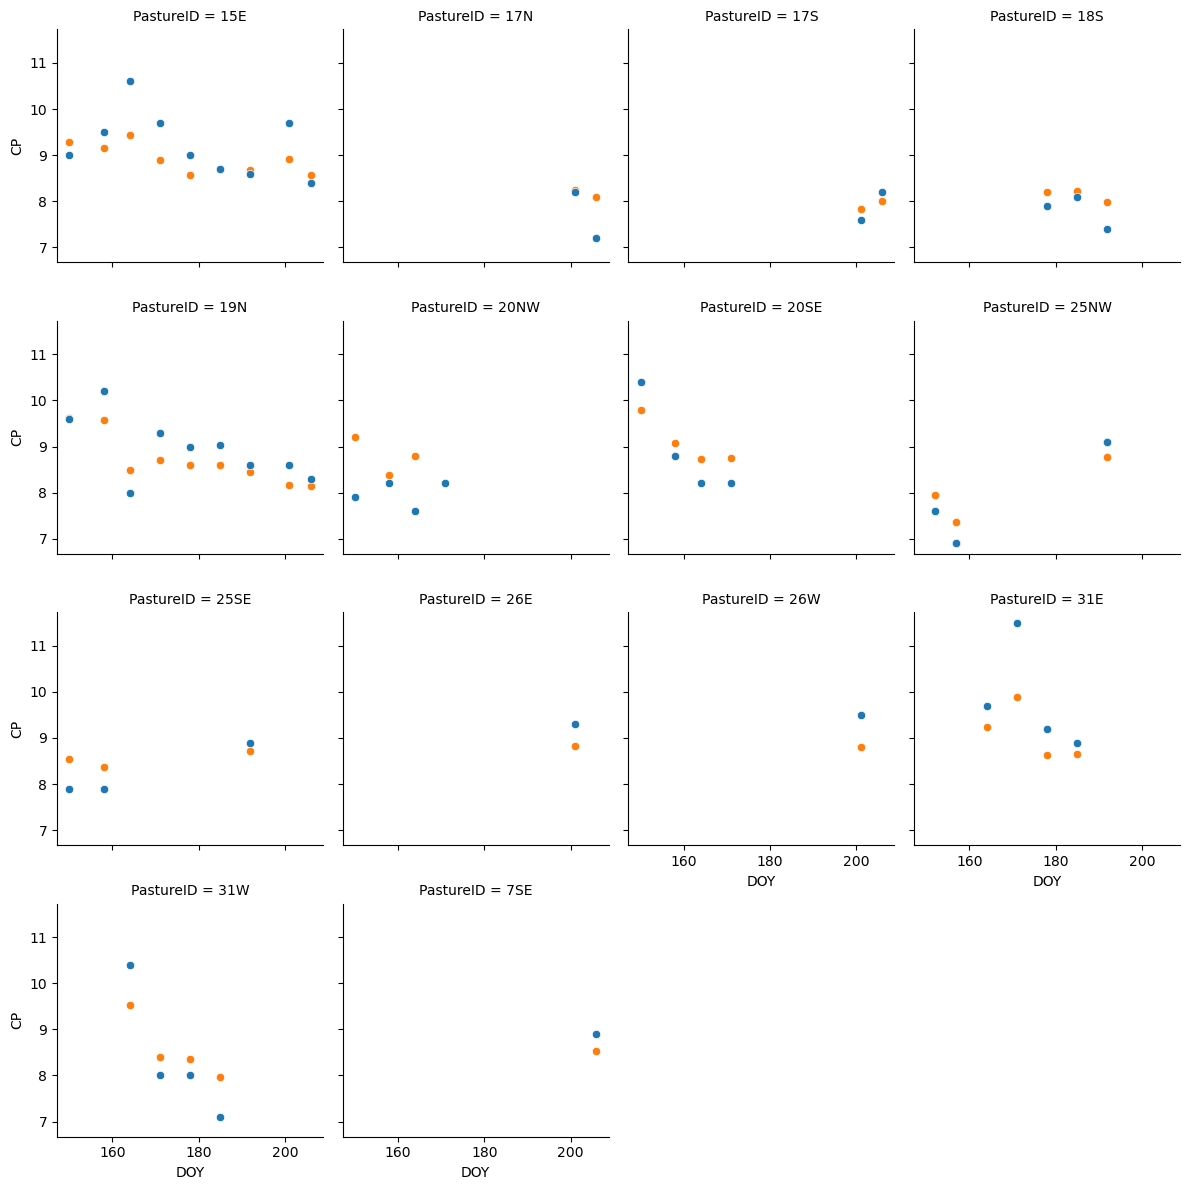

In [640]:
g = sns.FacetGrid(data=df_fq[df_fq['Year'] == '2022'], col='PastureID', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='DOY', y='CP_pred', color='tab:orange')
g.map_dataframe(sns.scatterplot, x='DOY', y='CP')

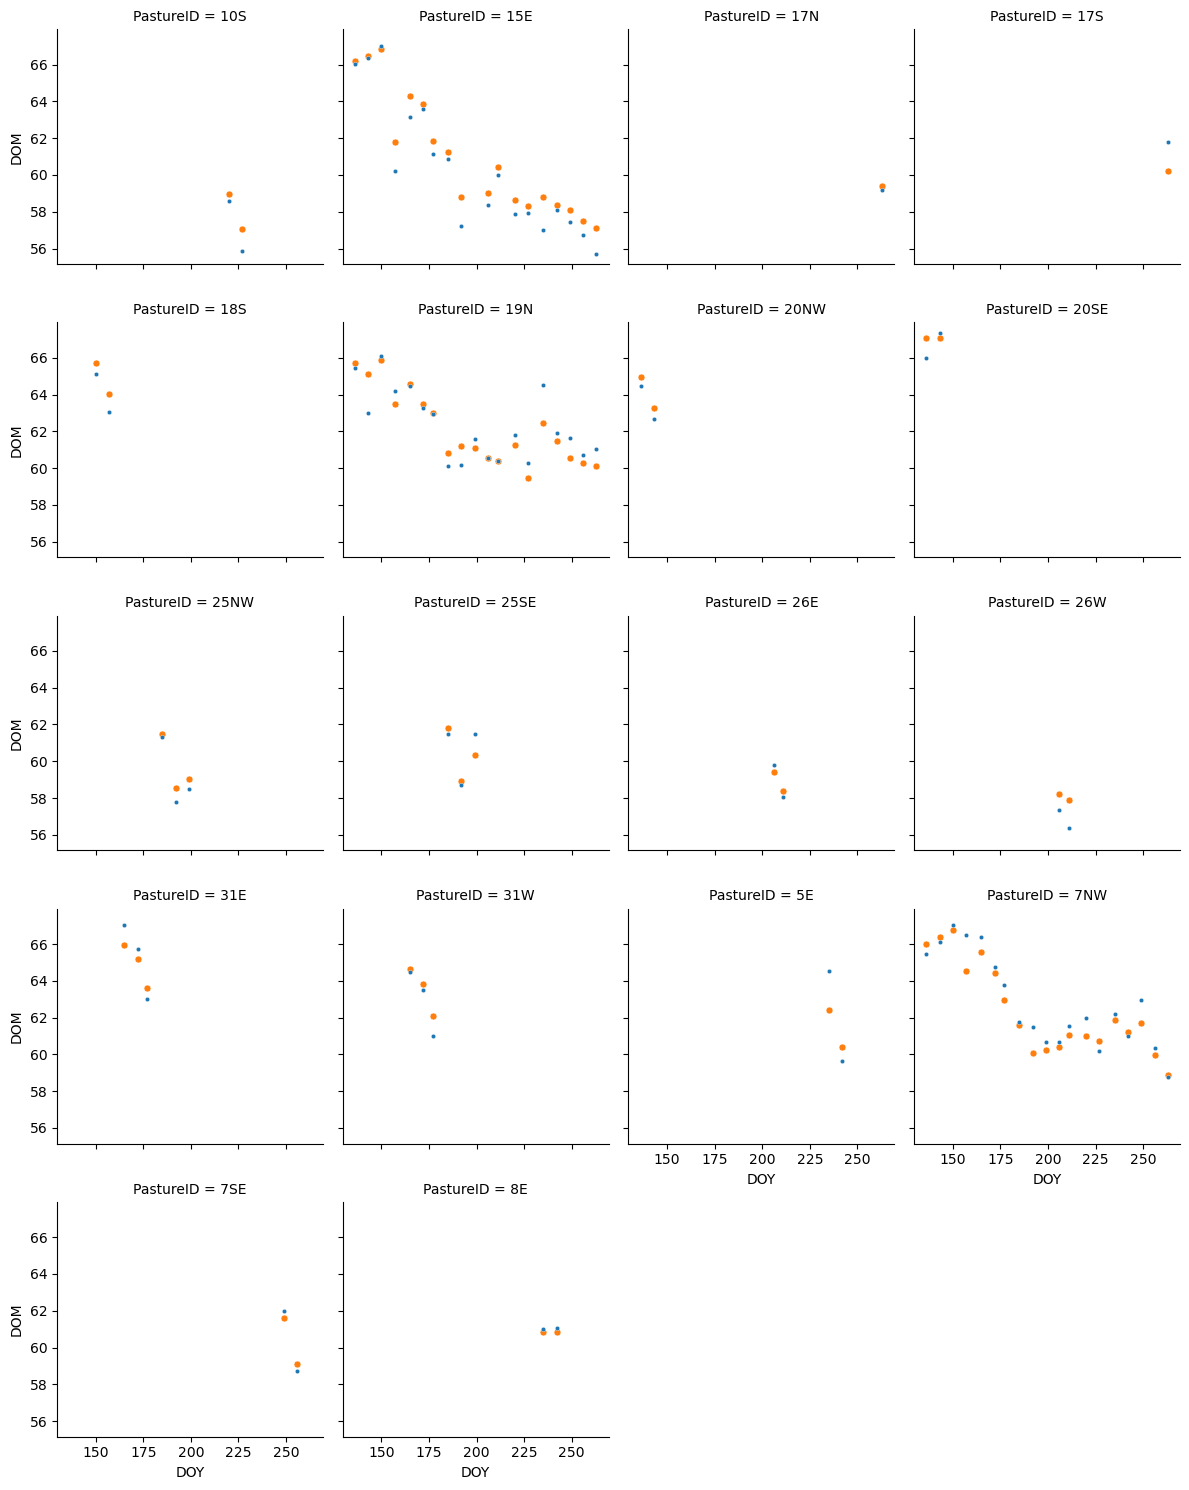

In [641]:
g = sns.FacetGrid(data=df_fq[df_fq['Year'] == '2018'], col='PastureID', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='DOY', y='DOM_pred', color='tab:orange', s=25)
g.map_dataframe(sns.scatterplot, x='DOY', y='DOM', color='tab:blue', s=10)

In [642]:
r2_trm_cp = r2_score(df_fq['CP'][df_fq['Treatment'] == 'TRM'], 
                     df_fq['CP_pred'][df_fq['Treatment'] == 'TRM'])
r_trm_cp, _ = stats.pearsonr(df_fq['CP'][df_fq['Treatment'] == 'TRM'], 
                     df_fq['CP_pred'][df_fq['Treatment'] == 'TRM'])
bias_trm_cp = np.mean(df_fq['CP_pred'][df_fq['Treatment'] == 'TRM'] - df_fq['CP'][df_fq['Treatment'] == 'TRM'])

r2_carm_cp = r2_score(df_fq['CP'][df_fq['Treatment'] == 'CARM'], 
                     df_fq['CP_pred'][df_fq['Treatment'] == 'CARM'])
r_carm_cp, _ = stats.pearsonr(df_fq['CP'][df_fq['Treatment'] == 'CARM'], 
                     df_fq['CP_pred'][df_fq['Treatment'] == 'CARM'])
bias_carm_cp = np.mean(df_fq['CP_pred'][df_fq['Treatment'] == 'CARM'] - df_fq['CP'][df_fq['Treatment'] == 'CARM'])

r2_trm_dom = r2_score(df_fq['DOM'][df_fq['Treatment'] == 'TRM'], 
                     df_fq['DOM_pred'][df_fq['Treatment'] == 'TRM'])
r_trm_dom, _ = stats.pearsonr(df_fq['DOM'][df_fq['Treatment'] == 'TRM'], 
                     df_fq['DOM_pred'][df_fq['Treatment'] == 'TRM'])
bias_trm_dom = np.mean(df_fq['DOM_pred'][df_fq['Treatment'] == 'TRM'] - df_fq['DOM'][df_fq['Treatment'] == 'TRM'])

r2_carm_dom = r2_score(df_fq['DOM'][df_fq['Treatment'] == 'CARM'], 
                     df_fq['DOM_pred'][df_fq['Treatment'] == 'CARM'])
r_carm_dom, _ = stats.pearsonr(df_fq['DOM'][df_fq['Treatment'] == 'CARM'], 
                     df_fq['DOM_pred'][df_fq['Treatment'] == 'CARM'])
bias_carm_dom = np.mean(df_fq['DOM_pred'][df_fq['Treatment'] == 'CARM'] - df_fq['DOM'][df_fq['Treatment'] == 'CARM'])

Text(0, 0.5, '')

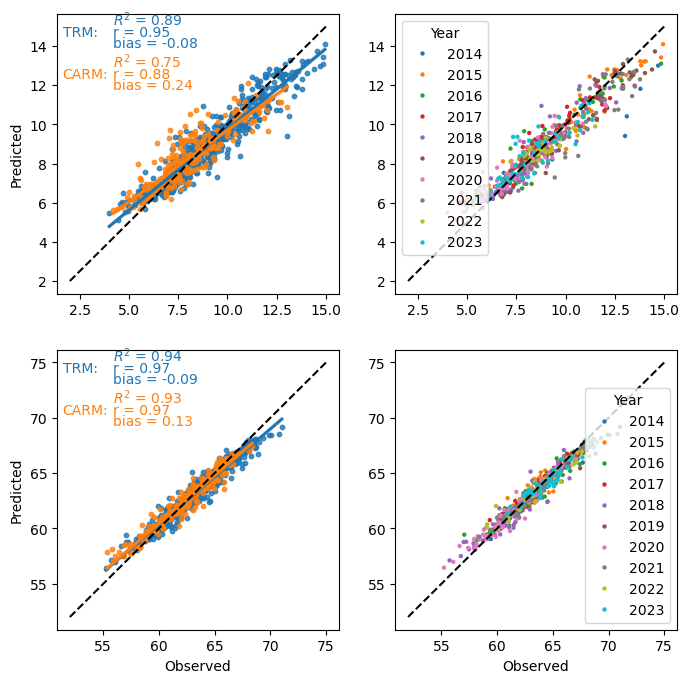

In [643]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.regplot(x='CP', y='CP_pred', data=df_fq[df_fq['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[0,0])
sns.regplot(x='CP', y='CP_pred', data=df_fq[df_fq['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[0,0])
axs[0,0].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[0,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_trm_cp),
                  xy=(.20, .96), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("r = {:.2f}".format(r_trm_cp),
                  xy=(.20, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("bias = {:.2f}".format(bias_trm_cp),
                  xy=(.20, .88), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_carm_cp),
                  xy=(.20, .81), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("r = {:.2f}".format(r_carm_cp),
                  xy=(.20, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("bias = {:.2f}".format(bias_carm_cp),
                  xy=(.20, .73), xycoords=axs[0,0].transAxes, color='tab:orange')


sns.regplot(x='DOM', y='DOM_pred', data=df_fq[df_fq['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[1,0])
sns.regplot(x='DOM', y='DOM_pred', data=df_fq[df_fq['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[1,0])
axs[1,0].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')
axs[1,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_trm_dom),
                  xy=(.20, .96), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("r = {:.2f}".format(r_trm_dom),
                  xy=(.20, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("bias = {:.2f}".format(bias_trm_dom),
                  xy=(.20, .88), xycoords=axs[1,0].transAxes, color='tab:blue')

axs[1,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_carm_dom),
                  xy=(.20, .81), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("r = {:.2f}".format(r_carm_dom),
                  xy=(.20, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("bias = {:.2f}".format(bias_carm_dom),
                  xy=(.20, .73), xycoords=axs[1,0].transAxes, color='tab:orange')

sns.scatterplot(x='CP', y='CP_pred', hue='Year', data=df_fq[df_fq['Treatment'] == 'TRM'], 
            s=10, edgecolor='none',
            ax=axs[0,1])
sns.scatterplot(x='DOM', y='DOM_pred', hue='Year', data=df_fq[df_fq['Treatment'] == 'TRM'], 
            s=10, edgecolor='none',
            ax=axs[1,1])
axs[0,1].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[1,1].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')

#axs[0,0].set_title('With Steer Ct')
#axs[0,1].set_title('Without Steer Ct')
axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,0].set_ylabel('')
axs[0,1].set_ylabel('')
axs[0,0].set_ylabel('Predicted')
axs[1,0].set_ylabel('Predicted')
axs[1,0].set_xlabel('Observed')
axs[1,1].set_xlabel('Observed')
axs[1,1].set_ylabel('')

In [644]:
import pickle
pickle.dump(rf_cp_fnl, open('../models/diet_quality/rf_cp_ndvi_2014_2023.pkl', 'wb'))
pickle.dump(rf_dom_fnl, open('../models/diet_quality/rf_dom_ndvi_2014_2023.pkl', 'wb'))

In [645]:
df_fq['PastureID'].unique()

array(['17N', '17S', '18S', '19N', '20NW', '20SE', '25NW', '25SE', '26E',
       '26W', '5E', '7NW', '7SE', '8E', '10S', '15E', '21N', '24W', '31E',
       '31W'], dtype=object)

## Plot final variable dymanics

In [646]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

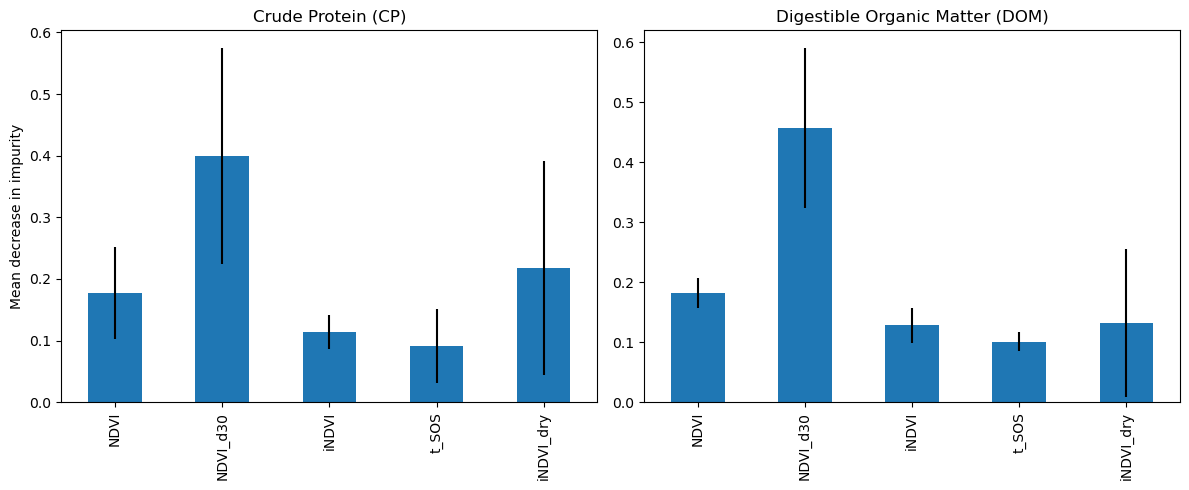

In [647]:
cp_importances = rf_cp_fnl.named_steps['RF'].feature_importances_
cp_importances_std = np.std([tree.feature_importances_ for tree in rf_cp_fnl.named_steps['RF'].estimators_], axis=0)
ps_cp_importances = pd.Series(cp_importances, index=feature_names_fnl)
dom_importances = rf_dom_fnl.named_steps['RF'].feature_importances_
dom_importances_std = np.std([tree.feature_importances_ for tree in rf_dom_fnl.named_steps['RF'].estimators_], axis=0)
ps_dom_importances = pd.Series(dom_importances, index=feature_names_fnl)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ps_cp_importances.plot.bar(yerr=cp_importances_std, ax=axs[0])
axs[0].set_title("Crude Protein (CP)")
ps_dom_importances.plot.bar(yerr=dom_importances_std, ax=axs[1])
axs[1].set_title("Digestible Organic Matter (DOM)")
axs[0].set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [88]:
from sklearn.inspection import partial_dependence
from tqdm.notebook import tqdm

In [89]:
def moving_average(x, w):
    xs = pd.Series(x)
    return xs.rolling(w, center=True, min_periods=1).mean()

In [93]:
var_label_dict = {'NDVI': 'rNDVI',
                  'NDVI_d30': 'dNDVI',
                  'iNDVI': 'iNDVI',
                  't_peak_IRG': 'tPEAK',
                  'iNDVI_dry': 'iDRY',
                  't_SOS': 'tSOS'}

var_title_dict = {'NDVI': 'rNDVI',
                  'NDVI_d30': 'dNDVI',
                  'iNDVI': 'iNDVI',
                  't_peak_IRG': 'tPEAK',
                  'iNDVI_dry': 'iDRY',
                  't_SOS': 'tSOS'}

### CP variable plots

In [91]:
pd_dict = {}
for idx, f in tqdm(enumerate(feature_names_fnl), total=len(feature_names_fnl)):
    pd_dict[f] = partial_dependence(rf_cp_fnl,
                                    df_sub[feature_names_fnl],
                                    [idx], 
                                    percentiles=(0.0, 1.0),
                                    kind='both')
    pd_dict[f]['mean_grid_value'] = np.argmin(np.abs(pd_dict[f]['grid_values'] - df_sub[feature_names_fnl[idx]].mean()))
    pd_dict[f]['individual_smooth'] = pd_dict[f]['individual'].squeeze().copy()
    for i in range(pd_dict[f]['individual_smooth'].shape[0]):
        pd_dict[f]['individual_smooth'][i,:] = moving_average(pd_dict[f]['individual'].squeeze()[i,:], 15)
    
    pd_dict[f]['individual_centered'] = pd_dict[f]['individual'].squeeze() - \
    pd_dict[f]['individual'].squeeze()[:,0, np.newaxis]
    pd_dict[f]['individual_centered_smooth'] = pd_dict[f]['individual_smooth'].squeeze() - \
    pd_dict[f]['individual_smooth'].squeeze()[:,0, np.newaxis]
    
    pd_dict[f]['individual_mean_centered'] = pd_dict[f]['individual'].squeeze() - \
    pd_dict[f]['individual'].squeeze()[:,pd_dict[f]['mean_grid_value'], np.newaxis]
    pd_dict[f]['individual_mean_centered_smooth'] = pd_dict[f]['individual_smooth'].squeeze() - \
    pd_dict[f]['individual_smooth'].squeeze()[:,pd_dict[f]['mean_grid_value'], np.newaxis]

  0%|          | 0/5 [00:00<?, ?it/s]

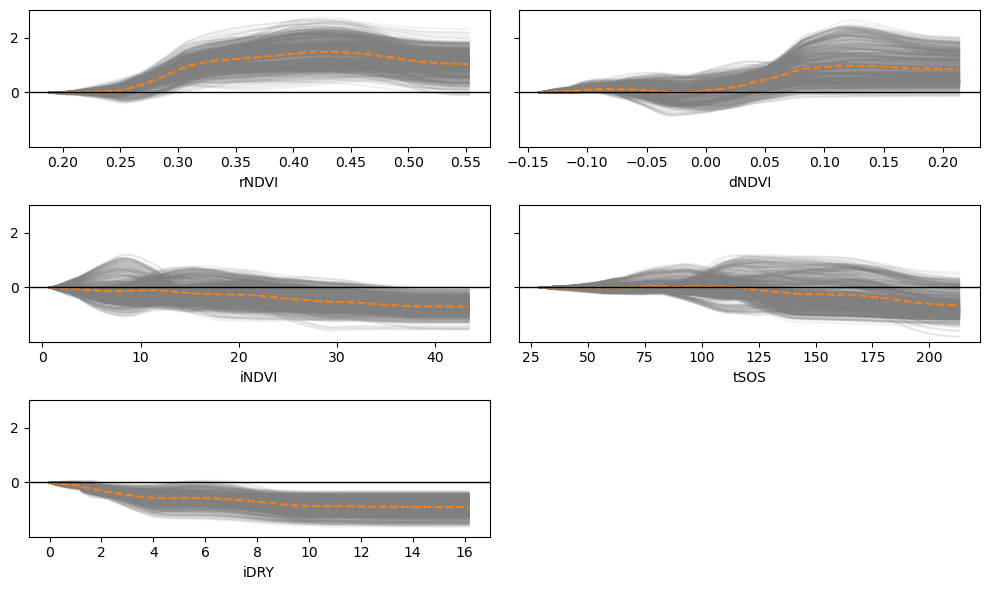

In [94]:
fig, axs = plt.subplots(nrows=int(np.ceil(len(feature_names_fnl)/2)), 
                        ncols=2, 
                        figsize=(10, 6), sharey=True)
for idx, f in enumerate(feature_names_fnl):
    for i in range(pd_dict[f]['individual_centered_smooth'].shape[0]):
        axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                pd_dict[f]['individual_centered_smooth'][i, :], color='grey', alpha=0.1)
    axs.flatten()[idx].plot(pd_dict[f]['grid_values'][0],
                            np.mean(pd_dict[f]['individual_centered_smooth'], axis=0), 
                            color='tab:orange', linestyle='dashed')
for idx, f in enumerate(feature_names_fnl):
    axs.flatten()[idx].set_ylim(min([np.min(pd_dict[f]['individual_centered_smooth']) for f in feature_names_fnl])*1.1,
                                max([np.max(pd_dict[f]['individual_centered_smooth']) for f in feature_names_fnl])*1.1)
    axs.flatten()[idx].axhline(y=0, color='black', linewidth=1)
    axs.flatten()[idx].set_xlabel(var_label_dict[feature_names_fnl[idx]])
for ax in axs.flatten()[len(feature_names_fnl):]:
    fig.delaxes(ax)
fig.tight_layout()

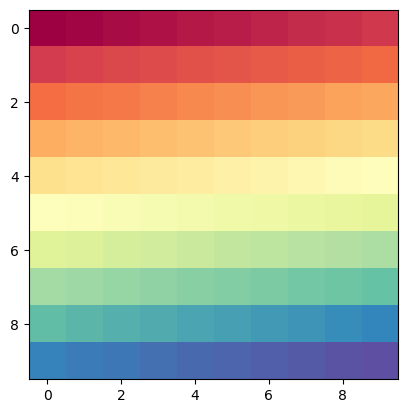

In [95]:
center='_centered'
import matplotlib.colors as mcolors
norm = mcolors.CenteredNorm()
cmap = sns.color_palette("Spectral", as_cmap=True)
#cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(df_sub)))
ax_tmp = plt.imshow(np.arange(100).reshape(10,10), cmap)

In [96]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as ptch
import matplotlib.transforms as mtrans

  0%|          | 0/5 [00:00<?, ?it/s]

/local/scratch/sean.kearney/16297667/ipykernel_378858/3579127529.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=1.75, h_pad=2.25)


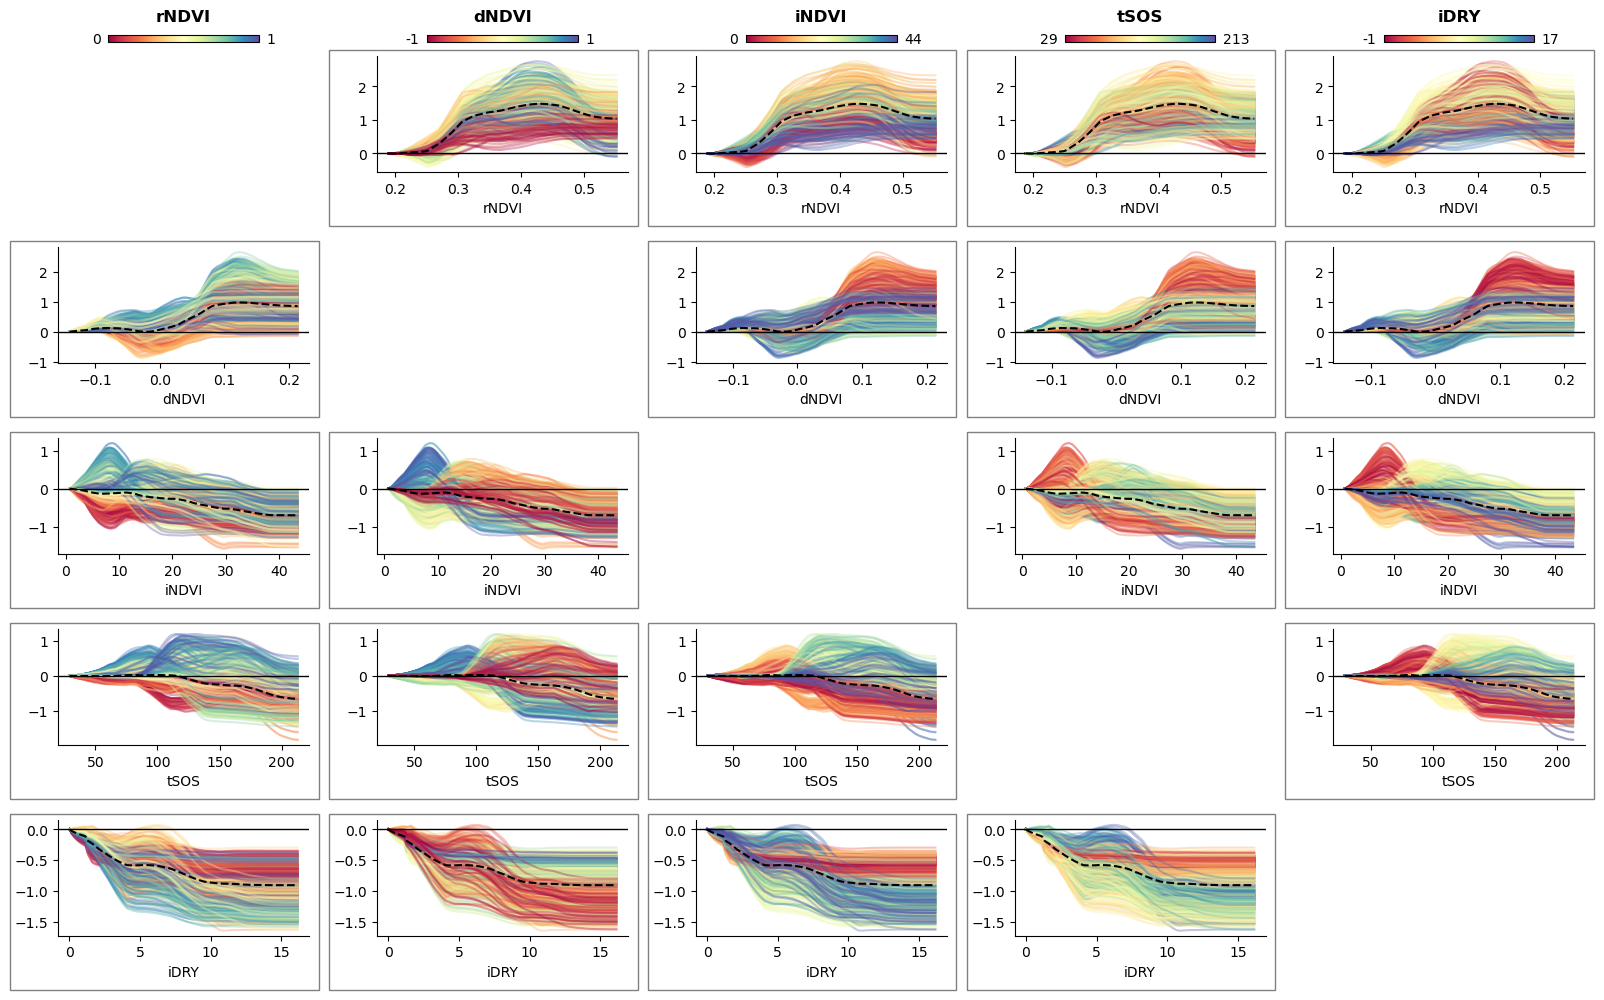

In [97]:
fig, axs = plt.subplots(ncols=len(feature_names_fnl), nrows=len(feature_names_fnl), 
                        figsize=(16,10))
fig.canvas.draw()
axs_ins = []
for idx_i, f_i in tqdm(enumerate(feature_names_fnl), total=len(feature_names_fnl)):
    for idx_j, f_j in enumerate(feature_names_fnl):
        if idx_i == 0:
            axs[idx_i, idx_j].set_title(var_label_dict[f_j], fontweight='bold', y=1.0, pad=25)
        if idx_i == idx_j:
            #fig.delaxes(axs[idx_i,idx_j])
            #axs[idx_i,idx_j].axis('off')
            #if idx_i == 0:
            #    axs[idx_i, idx_j].set_title(var_label_dict[f_j], fontweight='bold')
            axs[idx_i,idx_j].get_xaxis().set_visible(False)
            axs[idx_i,idx_j].get_yaxis().set_visible(False)
            continue
        else:
            f_j_centered = df_sub[f_j] - df_sub[f_j].mean()
            f_j_norm = f_j_centered.apply(lambda x: norm(x)).sort_values()
            f_j_norm = f_j_norm.reset_index()
            for i in range(pd_dict[feature_names_fnl[0]]['individual' + center + '_smooth'].shape[0]):
                axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                        pd_dict[f_i]['individual' + center + '_smooth'][i, :], 
                                       color=colors[f_j_norm[f_j_norm['index'] == i].index.values],
                                       alpha=0.35)
            axs[idx_i, idx_j].plot(pd_dict[f_i]['grid_values'][0],
                    np.mean(pd_dict[f_i]['individual' + center + '_smooth'], axis=0), 
                    color='black', linestyle='dashed')
            axs[idx_i, idx_j].set_xlabel(var_label_dict[f_i])
            axs[idx_i, idx_j].axhline(y=0, color='black', linewidth=1)
            axs[idx_i, idx_j].spines['top'].set_color('none')
            axs[idx_i, idx_j].spines['right'].set_color('none')
            #axs[idx_i, idx_j].set_title(f_j)
for i in range(len(feature_names_fnl)):
    axs_ins.append(inset_axes(axs[0, i],
                              width="60%",  
                              height="6%",
                              loc='upper center',
                              borderpad=-1.5
                             ))
    axs_ins
    cb = plt.colorbar(ax_tmp, cax=axs_ins[i], location='bottom', orientation='horizontal', ticks=[])
    cb.ax.text(-0.05, 0.4, str(int(np.floor(df_sub[feature_names_fnl[i]].min()))), 
               transform=cb.ax.transAxes, va='center', ha='right')
    cb.ax.text(1.05, 0.4, str(int(np.ceil(df_sub[feature_names_fnl[i]].max()))),
               transform=cb.ax.transAxes, va='center', ha='left')
fig.tight_layout(w_pad=1.75, h_pad=2.25)
box_pad = 0.03
for idx_i in range(len(feature_names_fnl)):
    for idx_j in range(len(feature_names_fnl)):
        ax = axs[idx_i, idx_j]
        if idx_i == idx_j:
            ax.set_frame_on(False)
            continue
        else:
            #if (idx_i == 0) & (idx_j > 1):
            #    ax.yaxis.set_ticklabels([])
            #elif (idx_i > 0) * (idx_j > 0):
            #    ax.yaxis.set_ticklabels([])
            pos = ax.get_position()
            # Create a rectangle patch
            rect = ptch.Rectangle((pos.x0-box_pad, pos.y0-box_pad*1.8), 
                                  pos.width+box_pad+box_pad*0.2, pos.height+box_pad*1.8+box_pad*0.2,
                                  linewidth=1, edgecolor='grey', facecolor='none', transform=fig.transFigure)
            # Add the rectangle to the figure
            fig.patches.append(rect)

#for yy in [0.203, 0.402, 0.602, 0.801]:
#    line = plt.Line2D([yy, yy], [0,1], transform=fig.transFigure, color="black")
#    fig.add_artist(line)

In [138]:
########################################################
cp_levels = np.arange(6.5, 12.5, 0.5)
cp_grid_res = 20
cp_percentiles = [0, 1]
cp_lines = True
cp_labels = False
fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], wspace=0.20)
gs_leg = mpl.gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.3], top=0.85, bottom=0.10)

<Figure size 1000x1000 with 0 Axes>

TypeError: matplotlib.axes._axes.Axes.contourf() got multiple values for keyword argument 'levels'

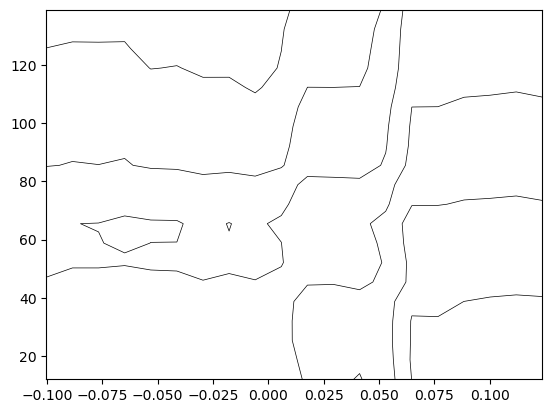

In [140]:
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                               df_sub[feature_names],
                                               [(1, 3)], 
                                               grid_resolution=cp_grid_res,
                                               #percentiles=(0,1), 
                                               contour_kw={'levels': cp_levels},
                                               n_jobs=-1)

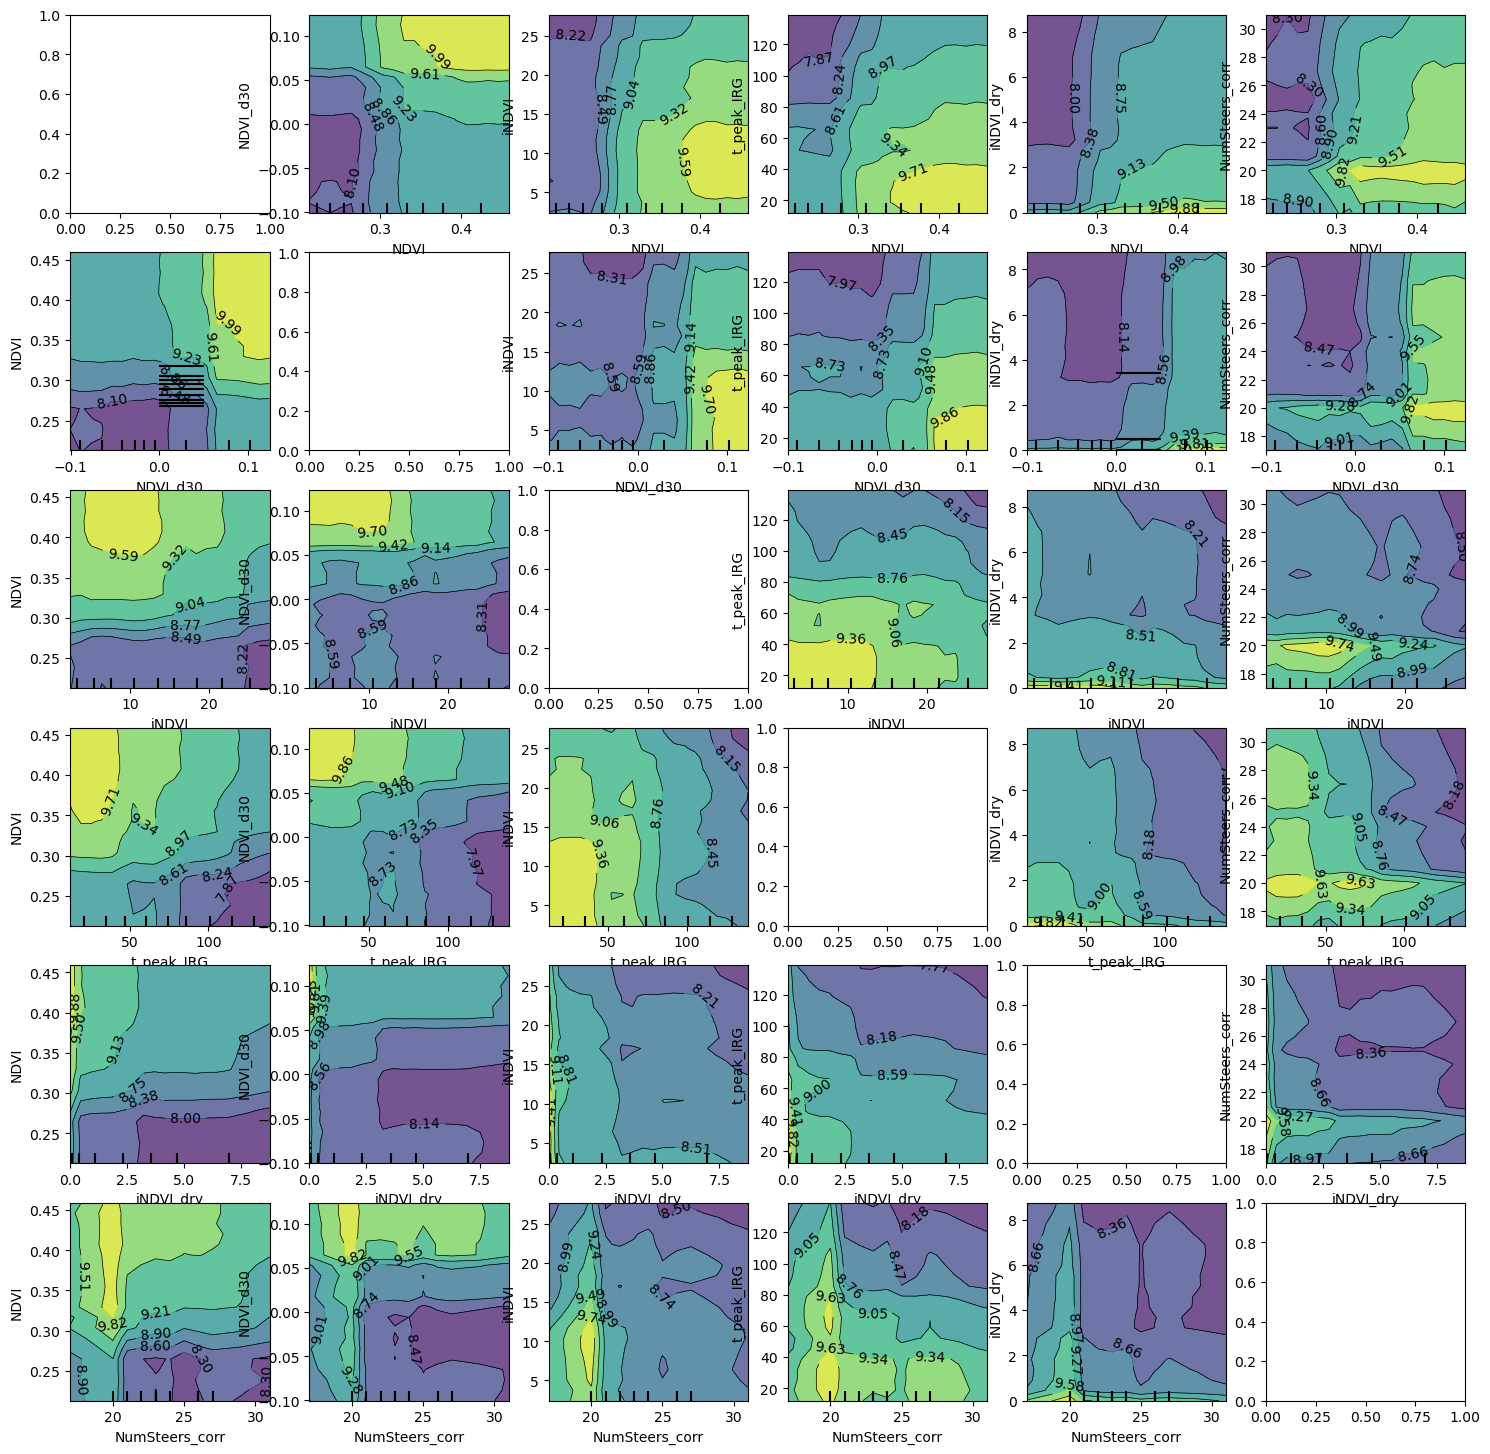

In [142]:
fig, axs = plt.subplots(nrows=len(feature_names), ncols=len(feature_names),
                        figsize=(18, 18), sharex=False, sharey=False)
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if i == j:
            continue
        else:
            PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                                    df_sub[feature_names],
                                                    [(i, j)], 
                                                    grid_resolution=cp_grid_res,
                                                    n_jobs=-1,
                                                    ax=axs[i,j])

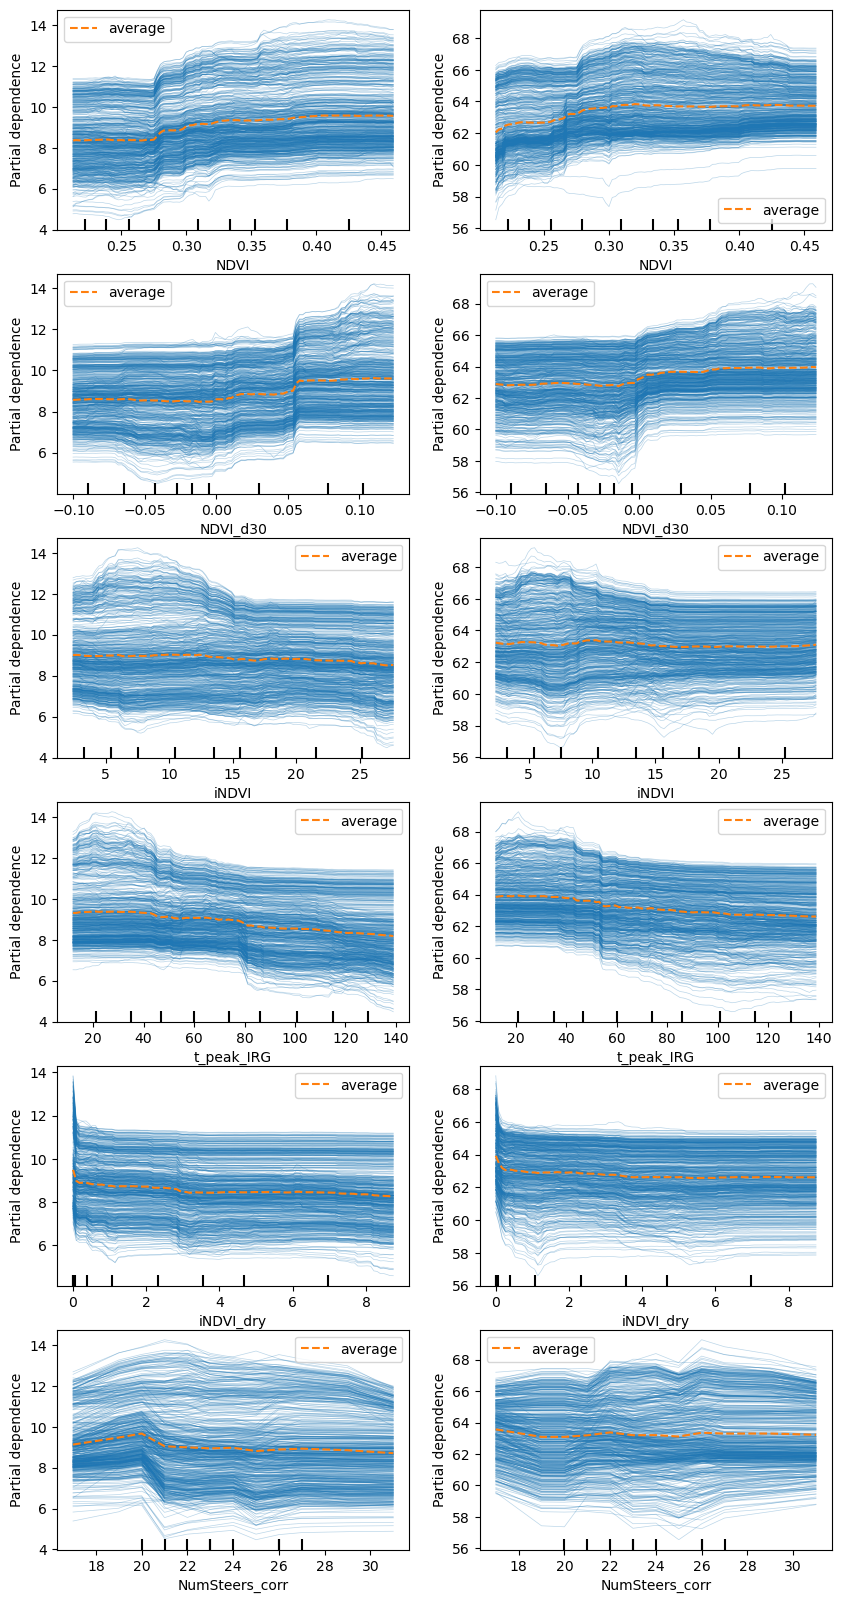

In [141]:
fig, axs = plt.subplots(nrows=len(feature_names), ncols=2, figsize=(10, 20), sharex=False)
for i in range(len(feature_names)):
    PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                            df_sub[feature_names],
                                            [i], 
                                            kind='both',
                                            ax=axs[i, 0],
                                            n_jobs=-1)
    PartialDependenceDisplay.from_estimator(rf_dom_fnl,
                                            df_sub[feature_names],
                                            [i], 
                                            kind='both',
                                            ax=axs[i, 1],
                                            n_jobs=-1)

In [75]:
ax1 = fig.add_subplot(gs[0, 0])
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(4, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax1,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax2 = fig.add_subplot(gs[0, 1])
pdp2 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax2,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp2.axes_[0][0].set_xlabel('')
pdp2.axes_[0][0].set_ylabel('')

ax3 = fig.add_subplot(gs[0, 2])
pdp3 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax3,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp3.axes_[0][0].set_xlabel('')
pdp3.axes_[0][0].set_ylabel('')

ax4 = fig.add_subplot(gs[0, 3])
pdp4 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax4,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp4.axes_[0][0].set_xlabel('')
pdp4.axes_[0][0].set_ylabel('')

ax5 = fig.add_subplot(gs[1, 1])
pdp5 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax5,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax6 = fig.add_subplot(gs[1, 2])
pdp6 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax6,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp6.axes_[0][0].set_xlabel('')
pdp6.axes_[0][0].set_ylabel('')

ax7 = fig.add_subplot(gs[1, 3])
pdp7 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax7,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp7.axes_[0][0].set_xlabel('')
pdp7.axes_[0][0].set_ylabel('')

ax8 = fig.add_subplot(gs[2, 2])
pdp8 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax8,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax9 = fig.add_subplot(gs[2, 3])
pdp9 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax9,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp9.axes_[0][0].set_xlabel('')
pdp9.axes_[0][0].set_ylabel('')

ax10 = fig.add_subplot(gs[3, 3])
pdp10 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 3)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax10,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

norm = mpl.colors.Normalize(vmin=6, vmax=12)
cm = plt.get_cmap('viridis')
ax_leg = plt.axes([0.05, 0.13, 0.5, 0.05])
ax_leg.set_title('CP (%)', fontsize=20, pad=25, loc='center')
bounds = np.arange(6, 12.5, 0.5)

cb1 = mpl.colorbar.ColorbarBase(ax_leg, cmap=cm,
                                norm=norm, spacing='proportional', boundaries=bounds,
                                orientation='horizontal')
ax_leg.tick_params(axis='both', labelsize=18)

for ax_i in [pdp1, pdp2, pdp3, pdp4, pdp5, pdp6, pdp7, pdp8, pdp9, pdp10]:
    ax_i.axes_[0][0].yaxis.label.set_size(14)
    ax_i.axes_[0][0].xaxis.label.set_size(14)
    ax_i.axes_[0][0].tick_params(axis='both',  labelsize=14)

gs.tight_layout(fig, w_pad=0, h_pad=0)
gs.update(wspace=0.30)
#gs_leg.tight_layout(fig, w_pad=0, h_pad=0)
#gs_leg.update(top=0.90, bottom=0.10, left=0.40)

TypeError: from_estimator() got an unexpected keyword argument 'levels'